![ieseg logo](./img/ieseg.png)

#### MBD 2020-2021
# Statistical & Machine Learning Approaches for Marketing

## Section 2: Classification

### 1. Import all required libraries and datasets

In [13]:
# Set environment params
Sys.setenv(LANG='en')  # English

# Import libraries
library(data.table)  # Data manipulate
library(mlr)         # ML toolkit
library(caret)       # ML toolkit
library(ggplot2)     # Visualization
library(pROC)        # AUC, ROC
library(e1071)       # Evaluation
library(gridExtra)   # Visualization
library(kknn)        # kNN model
library(nnet)        # One-vs-All Logistic Regression
library(dummies)     # Data processing

# Import data
library(ISLR)      # Data from the course book
library(MASS)      # Boston housing dataset
library(datasets)  # US crime dataset

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'caret'


The following object is masked from 'package:kknn':

    contr.dummy


The following object is masked from 'package:mlr':

    train


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'e1071'


The following object is masked from 'package:mlr':

    impute




[1] "R version 4.0.3 (2020-10-10)"

In [143]:
# Install missing packages
# install.packages(c("data.table", "mlr3", "caret", "ggplot2", "plotrix", "rgl", "ISLR", "MASS", "datasets"))
# install.packages(c("mlr", pROC", "e1071", "gridExtra", "kknn", "nnet", "dummies"))

### 2. Why not Linear Regression?

#### 2.1. The Credit Card Default Data

**Example 1:**

Q1: How many predictors? Types? Descriptive analysis?

Q2: The response has how many classes? Size of each class?

Q3: Make a quick analysis to see which predictor has the most predictability?

In [1]:
# Read the data
library(ISLR)
df <- Default

Warning message:
"package 'ISLR' was built under R version 3.6.3"

In [2]:
# Q1: How many predictors? Types? Descriptive analysis?
str(df)

'data.frame':	10000 obs. of  4 variables:
 $ default: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ student: Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 2 1 1 ...
 $ balance: num  730 817 1074 529 786 ...
 $ income : num  44362 12106 31767 35704 38463 ...


In [46]:
summary(df)

 default    student       balance           income     
 No :9667   No :7056   Min.   :   0.0   Min.   :  772  
 Yes: 333   Yes:2944   1st Qu.: 481.7   1st Qu.:21340  
                       Median : 823.6   Median :34553  
                       Mean   : 835.4   Mean   :33517  
                       3rd Qu.:1166.3   3rd Qu.:43808  
                       Max.   :2654.3   Max.   :73554  

In [47]:
# Q2: The response has how many classes? Size of each class?
table(df$default)
table(df$default)/nrow(df)


  No  Yes 
9667  333 


    No    Yes 
0.9667 0.0333 

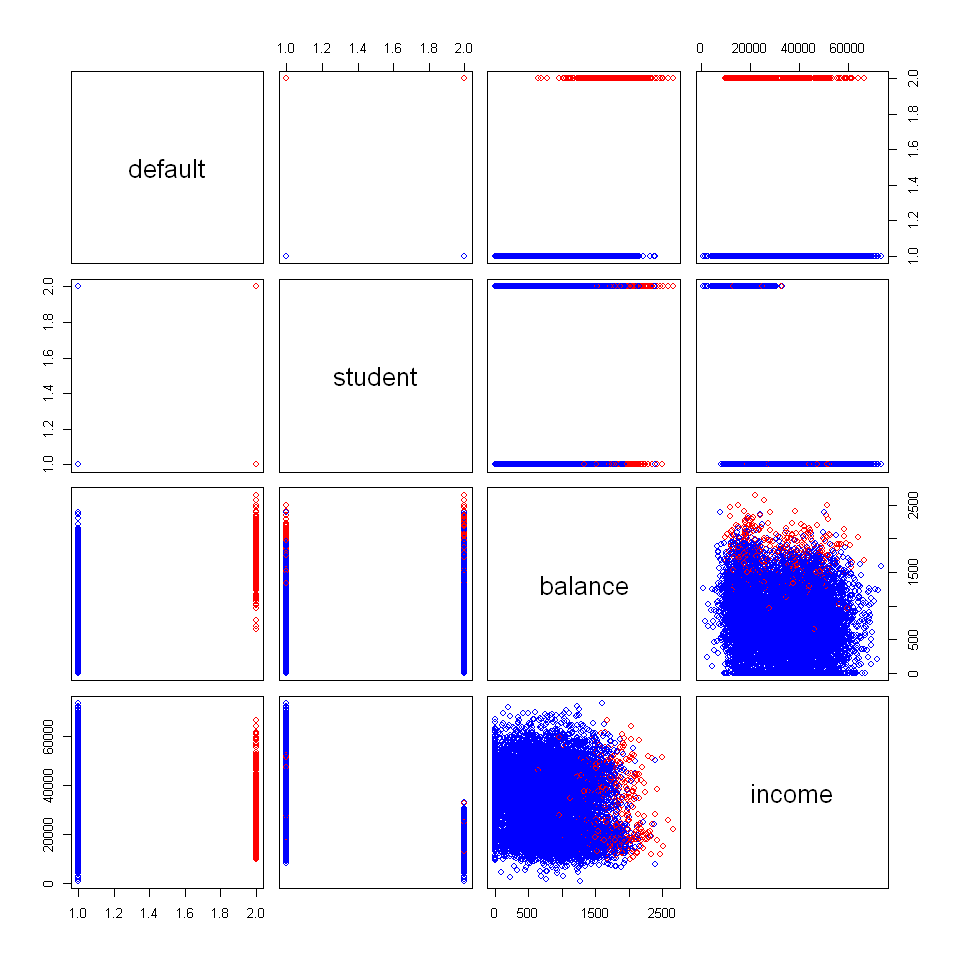

In [48]:
# Q3: Make a quick analysis to see which predictor has the most predictability?
# options(repr.plot.width=5, repr.plot.height=5)
cols <- rep('blue', nrow(df))  # Not default
cols[df$default == 'Yes'] <- 'red'  # Default
pairs(df, col=cols)

#### 2.2. Using Simple Linear Regression for classification problem: Credit Card Default Data

In [49]:
# Import and select a subset of Default data
library(ISLR)
df <- Default[, c('balance', 'default')]
str(df)

# Convert the response to [0, 1]
df$default <- df$default == 'Yes'

# Print out the incident rate
table(df$default)/nrow(df)

'data.frame':	10000 obs. of  2 variables:
 $ balance: num  730 817 1074 529 786 ...
 $ default: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...



 FALSE   TRUE 
0.9667 0.0333 

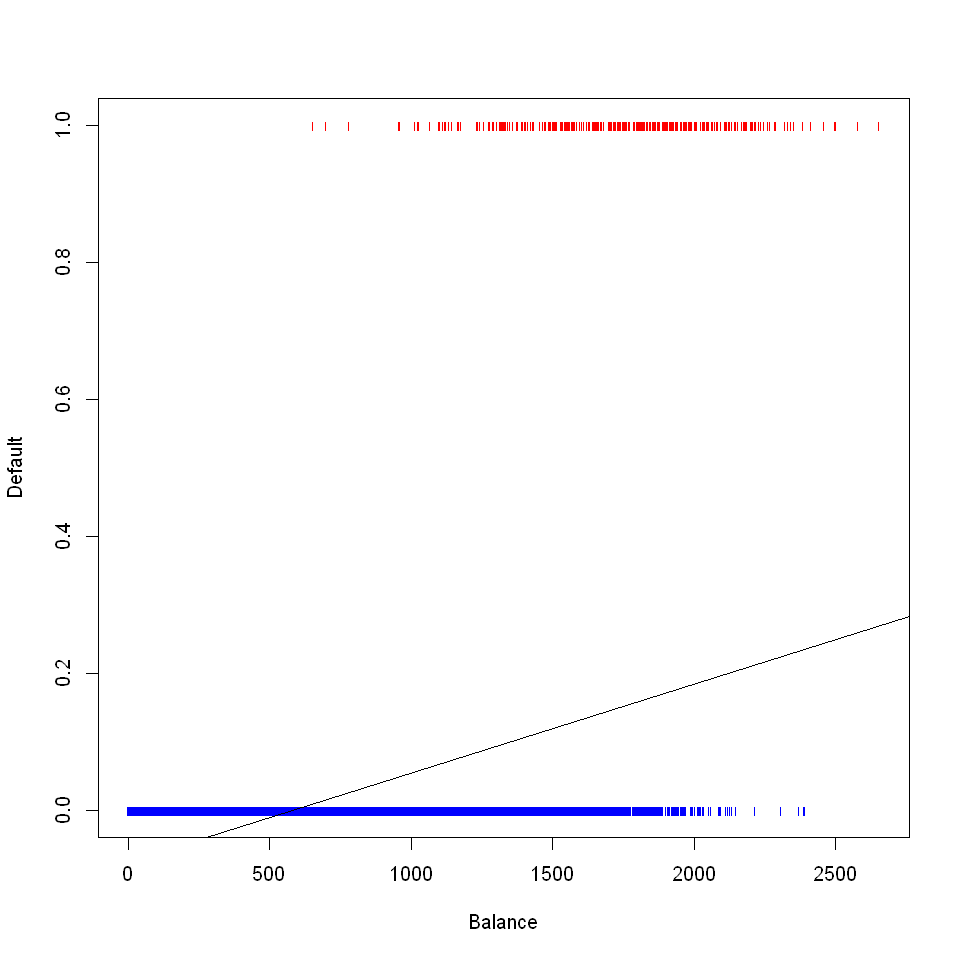

In [50]:
# Visualization the data
# options(repr.plot.width=6, repr.plot.height=4)
cols <- rep('blue', nrow(df))  # Not default
cols[df$default == TRUE] <- 'red'  # Default

plot(x=df$balance, y=df$default,  # Plot the data
     xlab='Balance', ylab='Default',
     pch='|', cex=0.5, col=cols)

abline(lm(default ~ balance, data=df))  # Plot the regression model

#### 2.3. Using Multilinear Regression for classification problem: Credit Card Default Data

**Example 2:**

Q1: Build a linear regression model to predict the default status  

Q2: Try with multiple values of the threshold the decide the class of the results  

Q3: Calculate the accuracy and AUC of each threshold value

In [51]:
# Import Default data
library(ISLR)
df <- Default
str(df)

# Print out the incident rate
table(df$default)/nrow(df)

'data.frame':	10000 obs. of  4 variables:
 $ default: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ student: Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 2 1 1 ...
 $ balance: num  730 817 1074 529 786 ...
 $ income : num  44362 12106 31767 35704 38463 ...



    No    Yes 
0.9667 0.0333 

In [52]:
# Train test separate with stratified
set.seed(123)
train_idx <- createDataPartition(df$default, p=.7, list=FALSE)
train <- df[train_idx, ]
test <- df[-train_idx, ]

In [53]:
# Q1: Build a linear regression model to predict the default status

# Encode the response before fiting to Linear Regression model
train_lr <- train
test_lr <- test
train_lr$default <- as.numeric(train_lr$default) - 1
test_lr$default <- as.numeric(test_lr$default) - 1

# Fit Linear Regression model
md_lr <- lm(default ~ ., data=train_lr)
summary(md_lr)


Call:
lm(formula = default ~ ., data = train_lr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24435 -0.06973 -0.02670  0.01995  0.97897 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.147e-02  1.005e-02  -7.113 1.25e-12 ***
studentYes  -1.914e-02  6.766e-03  -2.829  0.00468 ** 
balance      1.318e-04  4.252e-06  30.995  < 2e-16 ***
income       1.372e-08  2.290e-07   0.060  0.95222    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1686 on 6997 degrees of freedom
Multiple R-squared:  0.121,	Adjusted R-squared:  0.1206 
F-statistic: 321.1 on 3 and 6997 DF,  p-value: < 2.2e-16


In [54]:
# Q2: Try with multiple values of the threshold the decide the class of the results

# Predict and evaluate
pred <- predict(md_lr, newdata=test_lr)
head(pred)
summary(pred)

# Convert probability to class
threshold <- (table(df$default) / nrow(df))[2]
print(paste0('Decision threshold=', threshold))
pred_lb <- as.numeric(pred >= threshold)

6           12           19           23           24           26 
 0.030690553  0.070439827 -0.006579832  0.068405925  0.013559860  0.041563505

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.09045 -0.01254  0.03111  0.03353  0.07574  0.23085 

[1] "Decision threshold=0.0333"


In [55]:
# Q3: Calculate the accuracy and AUC of each threshold value

# Confusion matrix
caret::confusionMatrix(as.factor(pred_lb), as.factor(test_lr$default))

# AUC
pred_roc <- roc(pred_lb, test_lr$default)
pred_auc <- auc(pred_roc)
print(paste0('AUC=', pred_auc))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1544    1
         1 1356   98
                                          
               Accuracy : 0.5475          
                 95% CI : (0.5295, 0.5654)
    No Information Rate : 0.967           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0686          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.5324          
            Specificity : 0.9899          
         Pos Pred Value : 0.9994          
         Neg Pred Value : 0.0674          
             Prevalence : 0.9670          
         Detection Rate : 0.5148          
   Detection Prevalence : 0.5152          
      Balanced Accuracy : 0.7612          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC=0.533376512956113"


### 3. Logistic Regression

#### 3.1. Sigmoid function

In [56]:
# Defind the standard sigmoid function
sigmoid <- function(x) {
    1 / (1 + exp(-x))
}

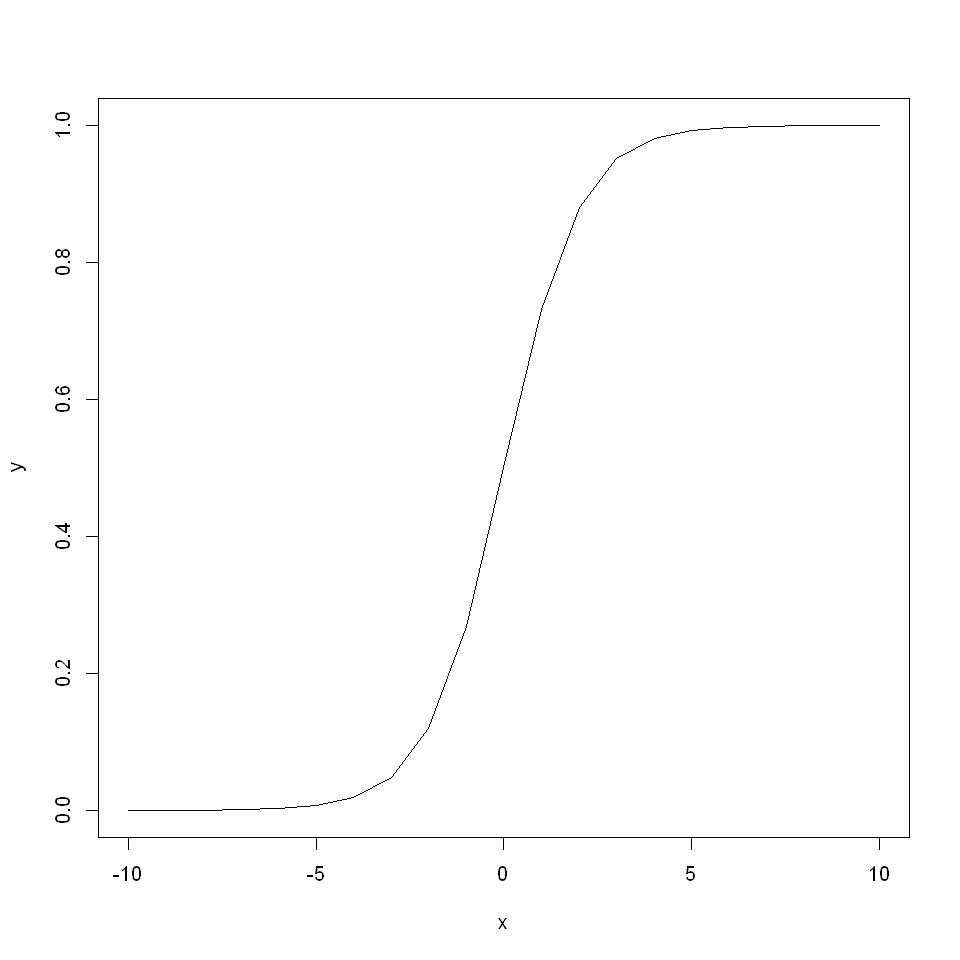

In [57]:
# Plot the sigmoid function
x <- seq(-10, 10)
y <- sigmoid(x)

# options(repr.plot.width=6, repr.plot.height=4)
plot(x, y, type='l')

#### 3.2. Example of Gradient Descent optimization algorithm

Ref: https://en.wikipedia.org/wiki/Gradient_descent

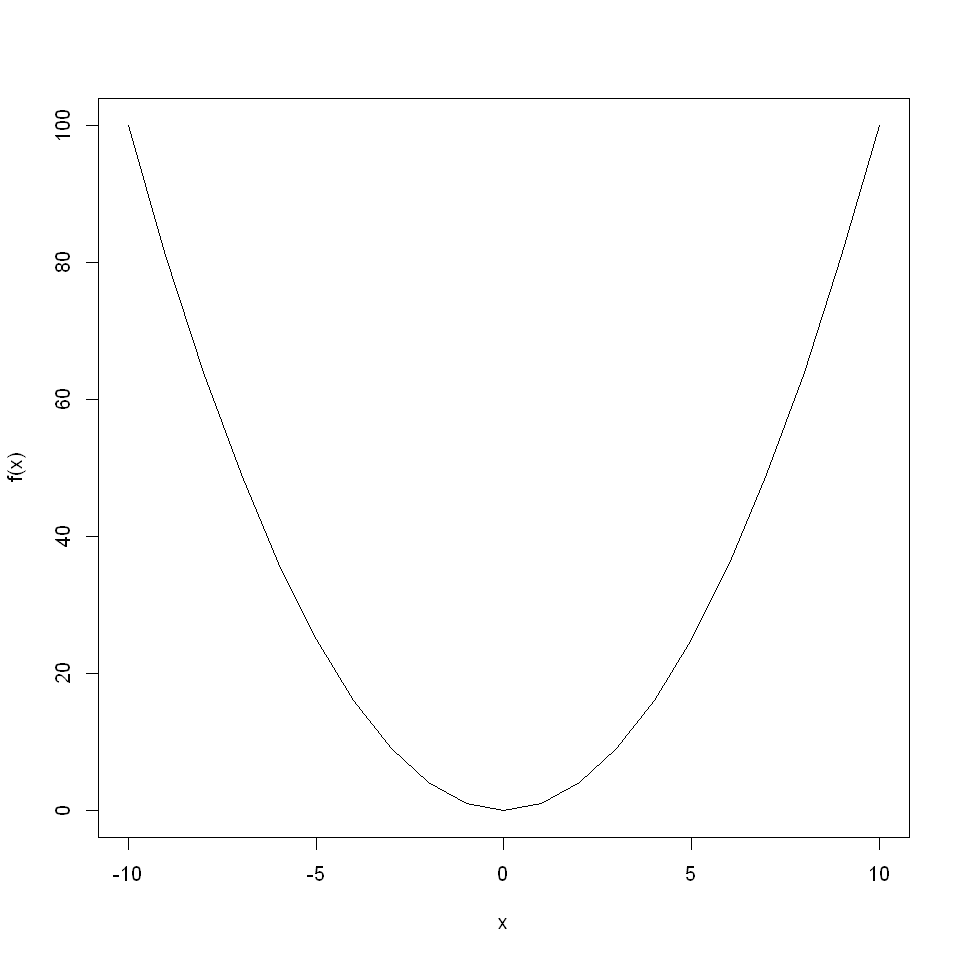

In [58]:
# Defind the objective function f(x) = x^2
objfun <- function(x) { x^2 }

# Generate value for x
x <- seq(-10, 10)

# Plot the function
# options(repr.plot.width=6, repr.plot.height=4)
plot(x, objfun(x), type='l',
     ylab='f(x)')

In [59]:
# Define the gradient of objective function
gradient <- function(x) return( 2*x )

# Set up a stepsize multiplier (learning rate)
gamma <- 0.003

# Set up a number of iterations
iter <- 500

# Randomly initialize a value to x
set.seed(100)
x <- floor(runif(1, 0, 10))
x0 <- x

# create a vector to contain all xs for all steps
x.All <- numeric(iter)

# Gradient descent method to find the minimum
for(i in seq_len(iter)){
        x <- x - gamma*gradient(x)
        x.All[i] <- x
}

[1] "Round = 100"
[1] "x = 1.64346210459692"
[1] "Round = 200"
[1] "x = 0.900322563082048"
[1] "Round = 300"
[1] "x = 0.493215338112973"
[1] "Round = 400"
[1] "x = 0.270193572531543"
[1] "Round = 500"
[1] "x = 0.14801763245375"


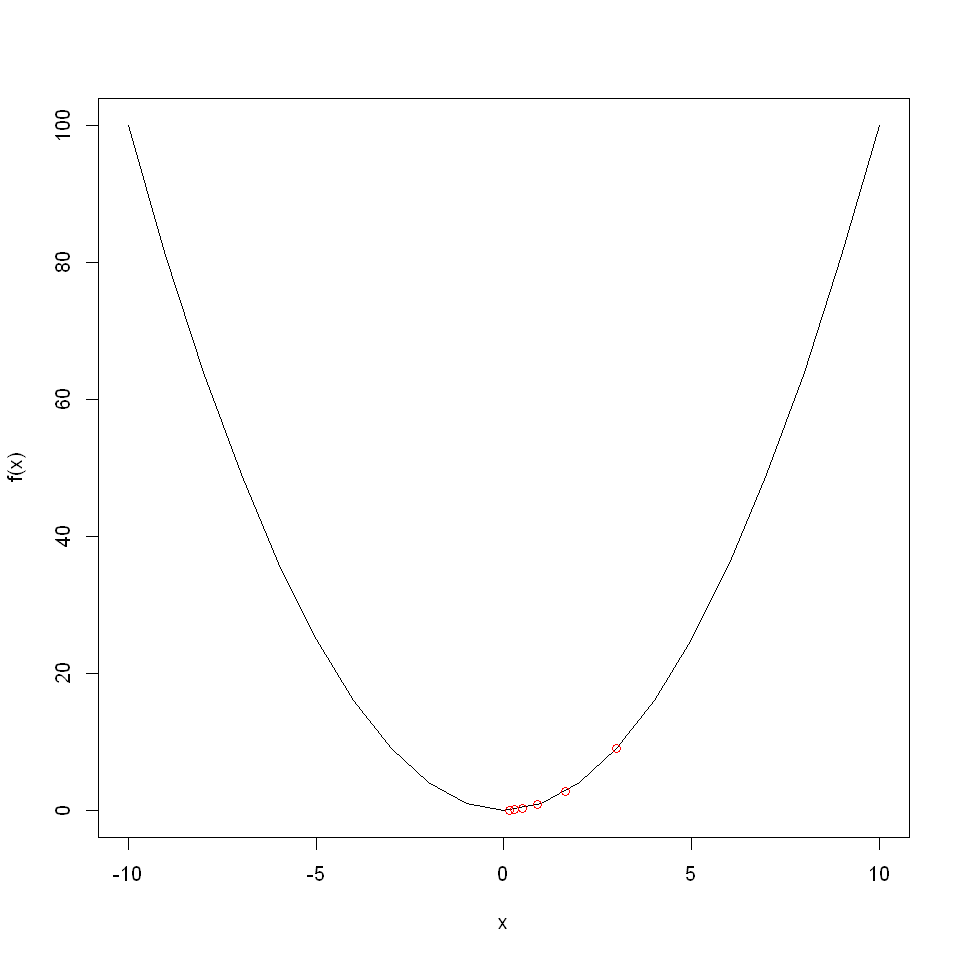

In [60]:
# Visualize the gradient descent
# options(repr.plot.width=6, repr.plot.height=4)

# Generate value for x
x <- seq(-10, 10)

# Initial the function plot
plot(x, objfun(x), type='l', ylab='f(x)')  # f(x)
points(x0, objfun(x0), col='red', bg='red')  # Initial the first random x point

# Plot the process of gradient descent
for(i in seq_len(iter)) {
    if (i %% 100 == 0) {
        points(x.All[i], objfun(x.All[i]), col='red', bg='red')  # Plot the new x and f(x)
        print(paste('Round =', i))  # Print the iteration
        print(paste('x =', x.All[i]))  # Print the new x value 
        Sys.sleep(1)  # 1s
    }
}

#### 3.3. Credit Card Default Data

**Single variable (p = 1)**

In [61]:
# Input data
library(ISLR)
df <- Default
str(df)

'data.frame':	10000 obs. of  4 variables:
 $ default: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ student: Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 1 2 1 1 ...
 $ balance: num  730 817 1074 529 786 ...
 $ income : num  44362 12106 31767 35704 38463 ...


In [62]:
# Convert the response to [0, 1]
df$default <- df$default == 'Yes'

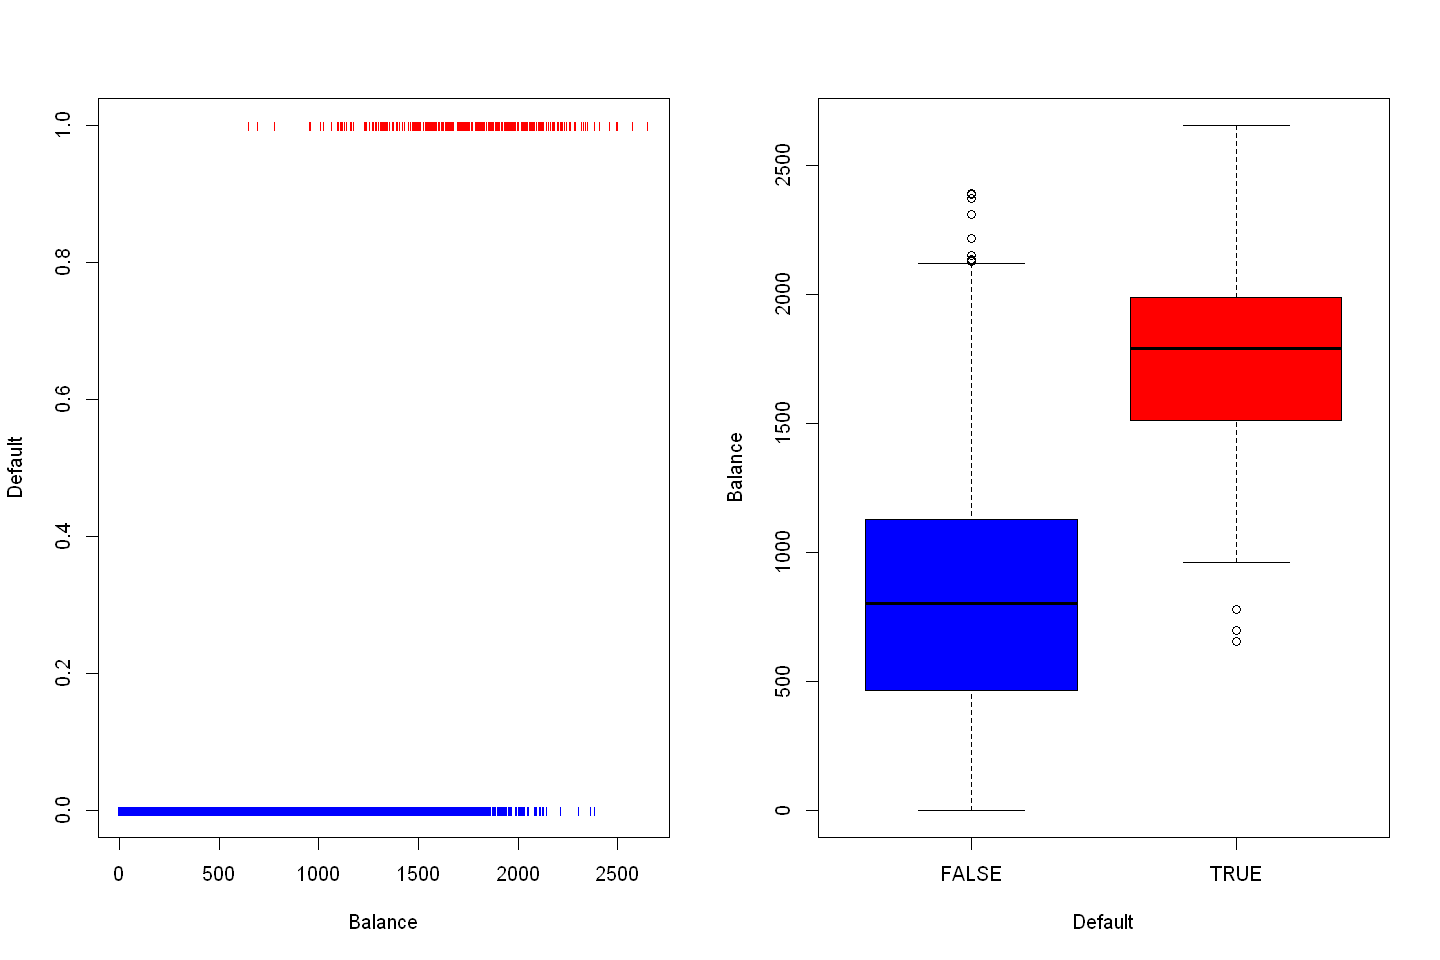

In [63]:
# Relationship between balance and default
options(repr.plot.width=12, repr.plot.height=8)
cols <- rep('blue', nrow(df))  # Not default
cols[df$default == TRUE] <- 'red'  # Default

par(mfrow=c(1, 2))

plot(x=df$balance, y=df$default,  # Plot the data
     xlab='Balance', ylab='Default',
     pch='|', cex=0.5, col=cols)

boxplot(balance ~ default, data=df,
        col=c('blue', 'red'),
        xlab='Default', ylab='Balance')

In [64]:
# Fit Logistic Regression model between balance and default
md_logreg <- glm(default ~ balance, data=df, family='binomial')
summary(md_logreg)


Call:
glm(formula = default ~ balance, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2697  -0.1465  -0.0589  -0.0221   3.7589  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.065e+01  3.612e-01  -29.49   <2e-16 ***
balance      5.499e-03  2.204e-04   24.95   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2920.6  on 9999  degrees of freedom
Residual deviance: 1596.5  on 9998  degrees of freedom
AIC: 1600.5

Number of Fisher Scoring iterations: 8


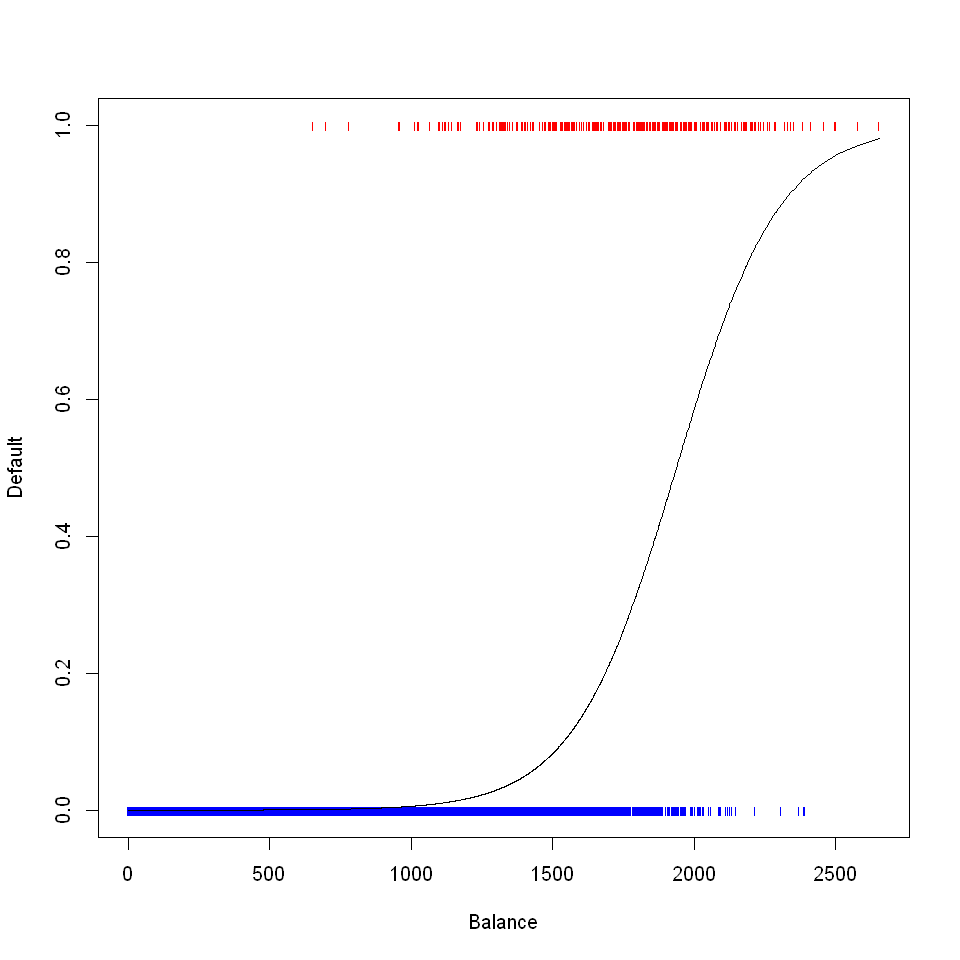

In [65]:
# Relationship between balance and default
options(repr.plot.width=8, repr.plot.height=8)
cols <- rep('blue', nrow(df))  # Not default
cols[df$default == TRUE] <- 'red'  # Default

plot(x=df$balance, y=df$default,  # Plot the data
     xlab='Balance', ylab='Default',
     pch='|', cex=0.5, col=cols)

# Prepare data for the Logistic Regression plot
df_sort <- df[order(df$balance), ]  # Sort the data
xweight <- df_sort$balance
yweight <- predict(md_logreg, df_sort, type="response")

lines(xweight, yweight)  # Plot the LR

In [66]:
# Fit Logistic Regression model between student and default
md_logreg <- glm(default ~ student, data=df, family='binomial')
summary(md_logreg)


Call:
glm(formula = default ~ student, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2970  -0.2970  -0.2434  -0.2434   2.6585  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.50413    0.07071  -49.55  < 2e-16 ***
studentYes   0.40489    0.11502    3.52 0.000431 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2920.6  on 9999  degrees of freedom
Residual deviance: 2908.7  on 9998  degrees of freedom
AIC: 2912.7

Number of Fisher Scoring iterations: 6


**Multiple variables (p > 1)**

In [67]:
# Fit Logistic Regression model between student and default
md_logreg <- glm(default ~ balance + income + student, data=df, family='binomial')
summary(md_logreg)


Call:
glm(formula = default ~ balance + income + student, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4691  -0.1418  -0.0557  -0.0203   3.7383  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.087e+01  4.923e-01 -22.080  < 2e-16 ***
balance      5.737e-03  2.319e-04  24.738  < 2e-16 ***
income       3.033e-06  8.203e-06   0.370  0.71152    
studentYes  -6.468e-01  2.363e-01  -2.738  0.00619 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2920.6  on 9999  degrees of freedom
Residual deviance: 1571.5  on 9996  degrees of freedom
AIC: 1579.5

Number of Fisher Scoring iterations: 8


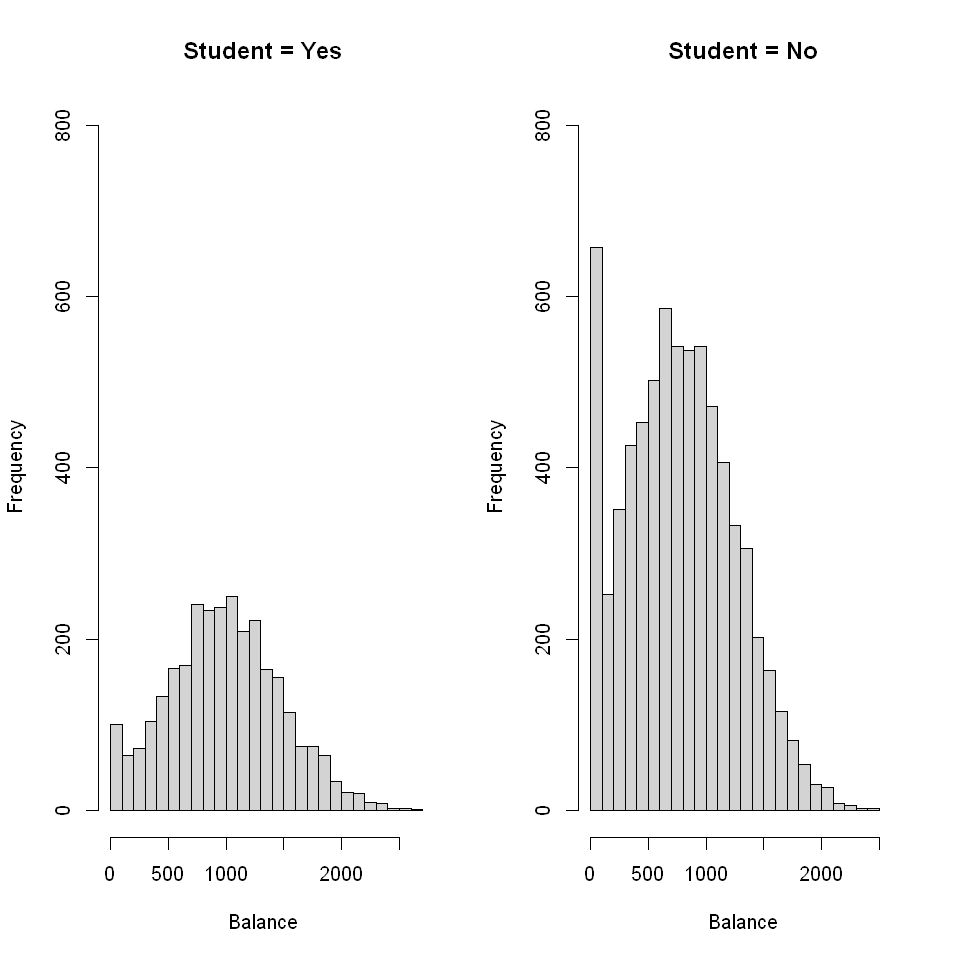

In [68]:
# Explain the negative coefficient of student
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(1, 2))
hist(df[df$student == 'Yes', 'balance'], breaks=20,
     xlim=c(0, max(df$balance)), ylim=c(0, 800),
     main='Student = Yes', xlab='Balance')
hist(df[df$student == 'No', 'balance'], breaks=20,
     xlim=c(0, max(df$balance)), ylim=c(0, 800),
     main='Student = No', xlab='Balance')

#### 3.4. South African Heart Disease Data

In [69]:
# Input data
# Source: https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.info.txt
# sbp       : systolic blood pressure
# tobacco   : cumulative tobacco (kg)
# ldl       : low densiity lipoprotein cholesterol
# adiposity : severely overweight status
# famhist   : family history of heart disease (Present, Absent)
# typea     : type-A behavior
# obesity   : obesity status
# alcohol   : current alcohol consumption
# age       : age at onset
# chd       : response, coronary heart disease
heart <- read.csv('./data/SAheart.csv', row.names=1)
str(heart)

'data.frame':	462 obs. of  10 variables:
 $ sbp      : int  160 144 118 170 134 132 142 114 114 132 ...
 $ tobacco  : num  12 0.01 0.08 7.5 13.6 6.2 4.05 4.08 0 0 ...
 $ ldl      : num  5.73 4.41 3.48 6.41 3.5 6.47 3.38 4.59 3.83 5.8 ...
 $ adiposity: num  23.1 28.6 32.3 38 27.8 ...
 $ famhist  : chr  "Present" "Absent" "Present" "Present" ...
 $ typea    : int  49 55 52 51 60 62 59 62 49 69 ...
 $ obesity  : num  25.3 28.9 29.1 32 26 ...
 $ alcohol  : num  97.2 2.06 3.81 24.26 57.34 ...
 $ age      : int  52 63 46 58 49 45 38 58 29 53 ...
 $ chd      : int  1 1 0 1 1 0 0 1 0 1 ...


In [70]:
# Cases and controls
table(heart$chd)


  0   1 
302 160 

In [71]:
head(heart)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0


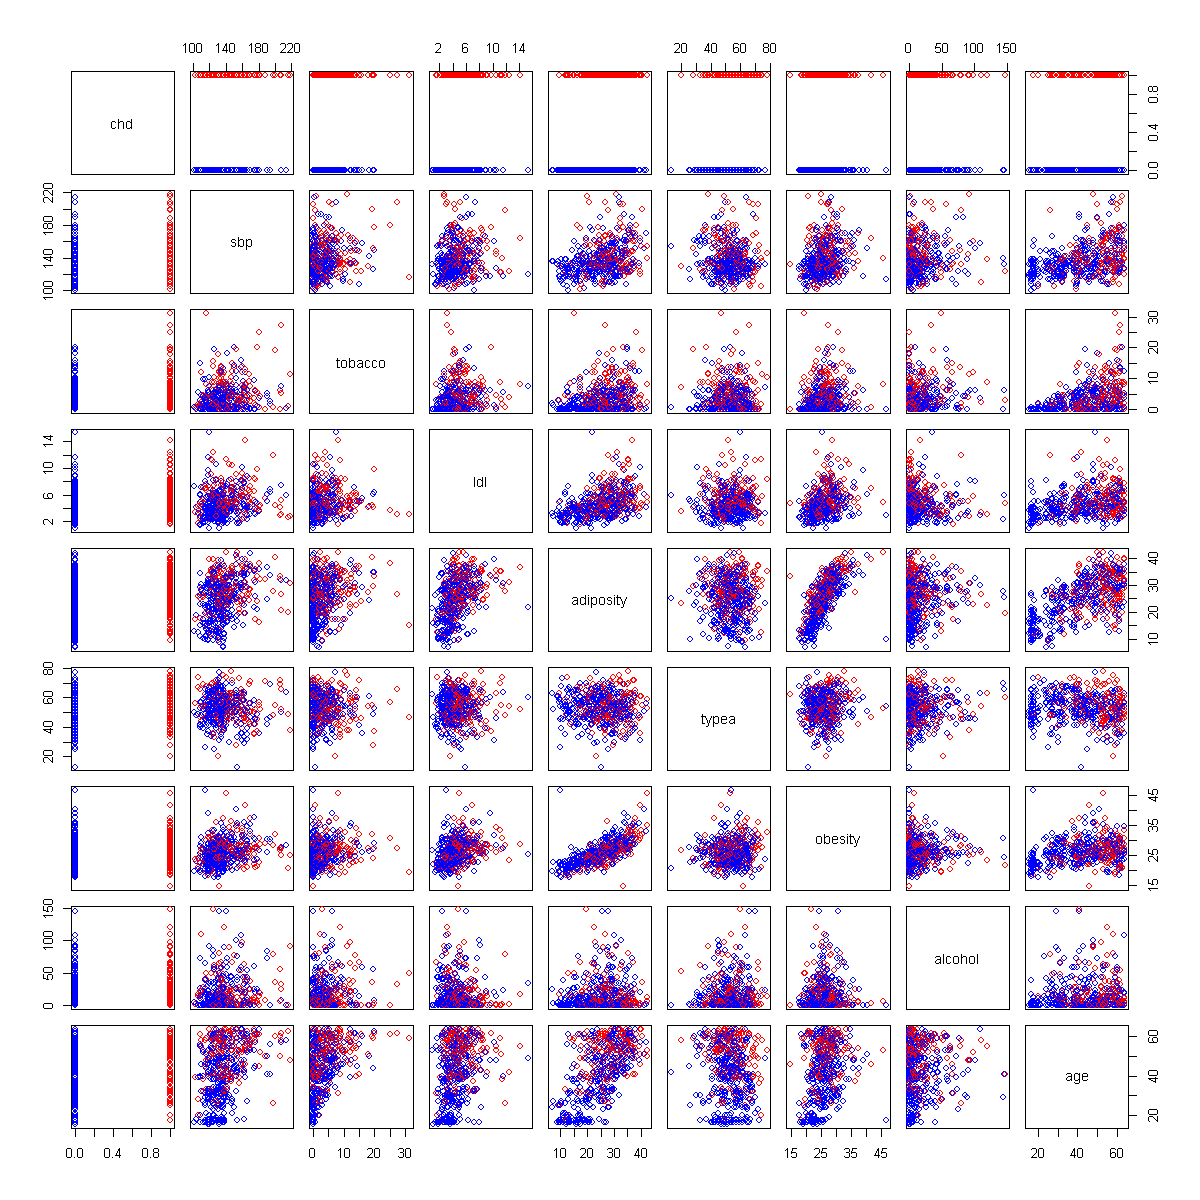

In [73]:
# Pair plot
options(repr.plot.width=10, repr.plot.height=10)
cols <- rep('red', nrow(heart))  # With heart disease
cols[heart$chd == 0] <- 'blue'  # No heart disease
pairs(chd ~ sbp + tobacco + ldl + adiposity + typea + obesity + alcohol + age, data=heart, col=cols)

**Example 6:** Build and interprete a logistic regression model to predict the heart disease (chd).

In [74]:
# Fit logistic regression model
md_logreg <- glm(chd ~ ., data=heart, family='binomial')
summary(md_logreg)


Call:
glm(formula = chd ~ ., family = "binomial", data = heart)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7781  -0.8213  -0.4387   0.8889   2.5435  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -6.1507209  1.3082600  -4.701 2.58e-06 ***
sbp             0.0065040  0.0057304   1.135 0.256374    
tobacco         0.0793764  0.0266028   2.984 0.002847 ** 
ldl             0.1739239  0.0596617   2.915 0.003555 ** 
adiposity       0.0185866  0.0292894   0.635 0.525700    
famhistPresent  0.9253704  0.2278940   4.061 4.90e-05 ***
typea           0.0395950  0.0123202   3.214 0.001310 ** 
obesity        -0.0629099  0.0442477  -1.422 0.155095    
alcohol         0.0001217  0.0044832   0.027 0.978350    
age             0.0452253  0.0121298   3.728 0.000193 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees

In [75]:
# Fit logistic regression model with only signiificant variables
md_logreg <- glm(chd ~ tobacco + ldl + famhist + typea + age , data=heart, family='binomial')
summary(md_logreg)


Call:
glm(formula = chd ~ tobacco + ldl + famhist + typea + age, family = "binomial", 
    data = heart)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9165  -0.8054  -0.4430   0.9329   2.6139  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -6.44644    0.92087  -7.000 2.55e-12 ***
tobacco         0.08038    0.02588   3.106  0.00190 ** 
ldl             0.16199    0.05497   2.947  0.00321 ** 
famhistPresent  0.90818    0.22576   4.023 5.75e-05 ***
typea           0.03712    0.01217   3.051  0.00228 ** 
age             0.05046    0.01021   4.944 7.65e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees of freedom
Residual deviance: 475.69  on 456  degrees of freedom
AIC: 487.69

Number of Fisher Scoring iterations: 5


### 4. Discriminant Analysis

#### 4.1. Linear Discriminant Analysis (LDA)

In [76]:
# Load data
data(iris)
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [77]:
# Print out the class
table(iris$Species)


    setosa versicolor  virginica 
        50         50         50 

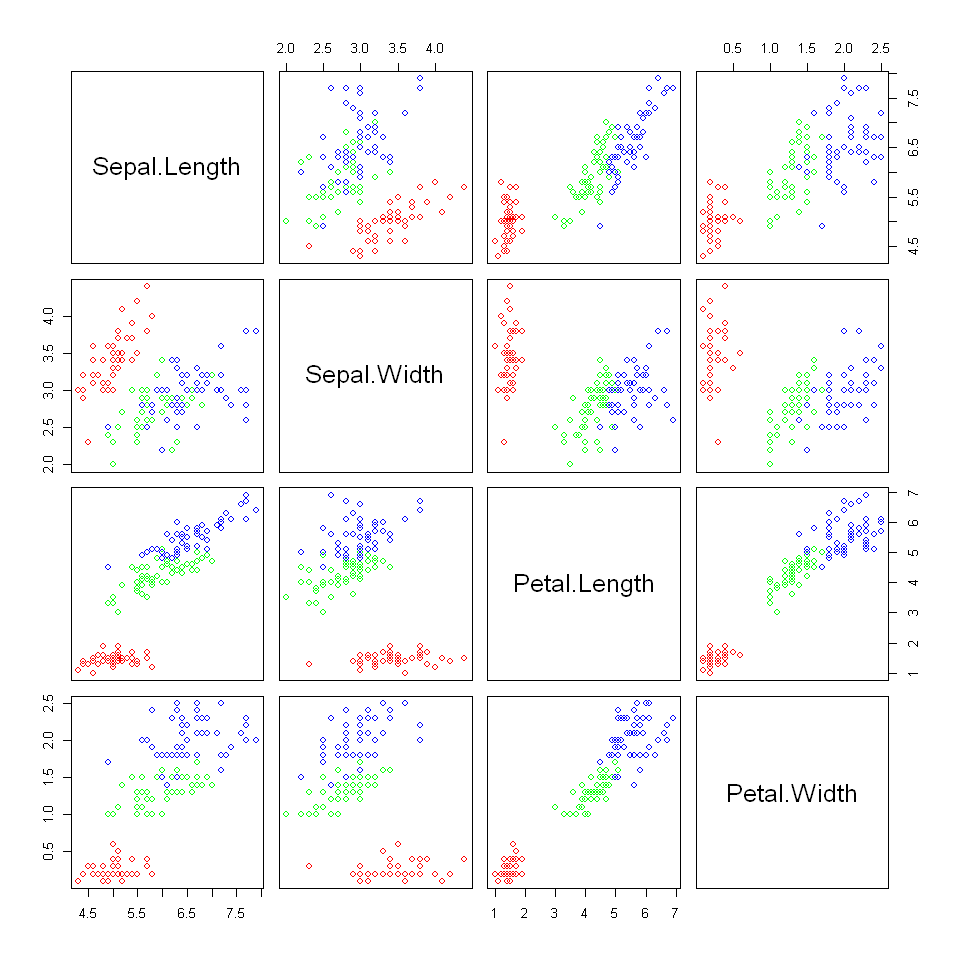

In [79]:
# Pair plot
options(repr.plot.width=8, repr.plot.height=8)
cols <- character(nrow(iris))
cols[] <- "black"
cols[iris$Species == "setosa"] <- "red"
cols[iris$Species == "versicolor"] <- "green"
cols[iris$Species == "virginica"] <- "blue"
pairs(iris[, -5], col=cols)

In [80]:
# Fit LDA model
library(MASS)
md_lda <- lda(Species ~ ., data=iris)
md_lda

Call:
lda(Species ~ ., data = iris)

Prior probabilities of groups:
    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

Group means:
           Sepal.Length Sepal.Width Petal.Length Petal.Width
setosa            5.006       3.428        1.462       0.246
versicolor        5.936       2.770        4.260       1.326
virginica         6.588       2.974        5.552       2.026

Coefficients of linear discriminants:
                    LD1         LD2
Sepal.Length  0.8293776  0.02410215
Sepal.Width   1.5344731  2.16452123
Petal.Length -2.2012117 -0.93192121
Petal.Width  -2.8104603  2.83918785

Proportion of trace:
   LD1    LD2 
0.9912 0.0088 

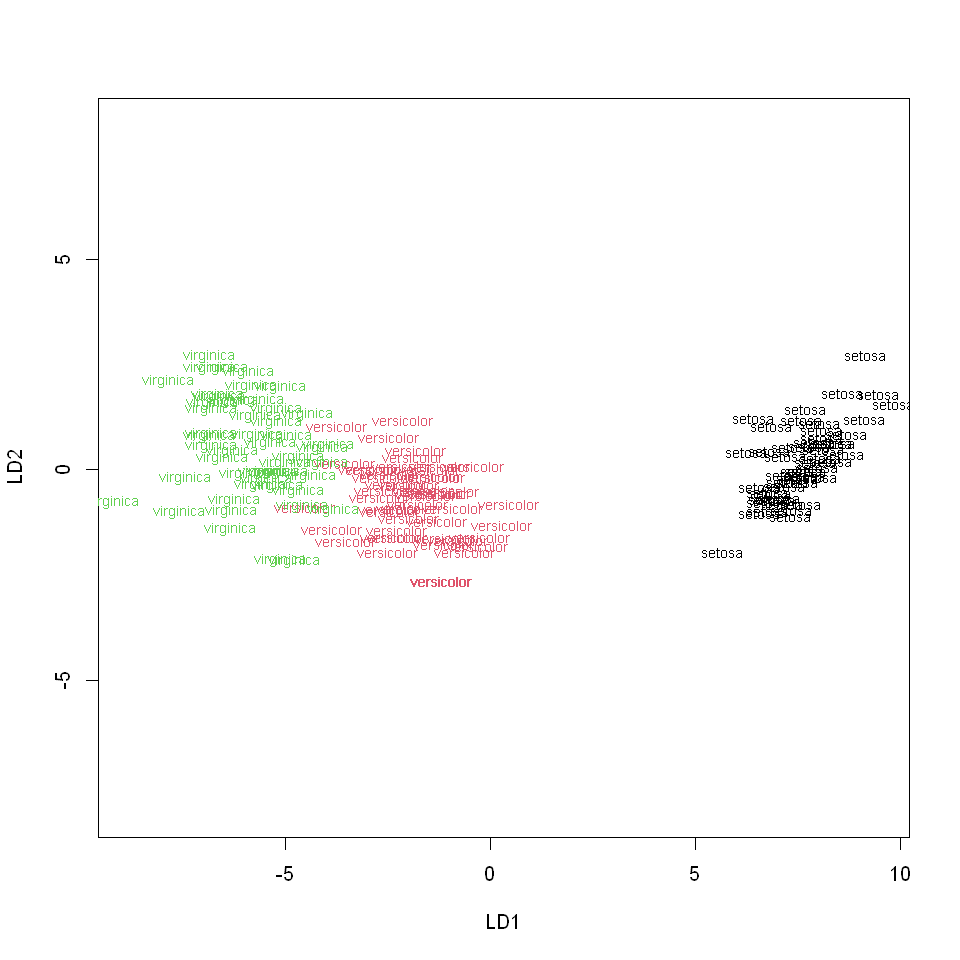

In [82]:
# Visualize the transformed data
options(repr.plot.width=8, repr.plot.height=8)
plot(md_lda, col=as.integer(iris$Species), pch=20)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



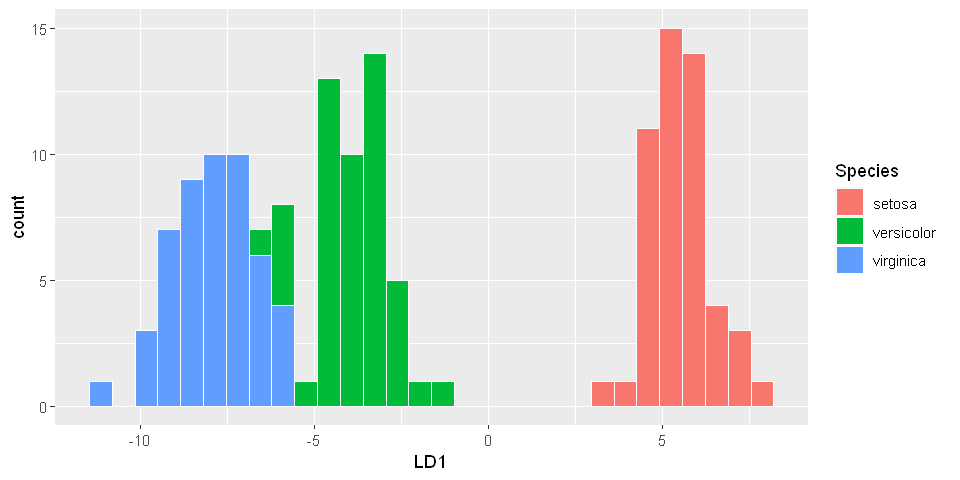

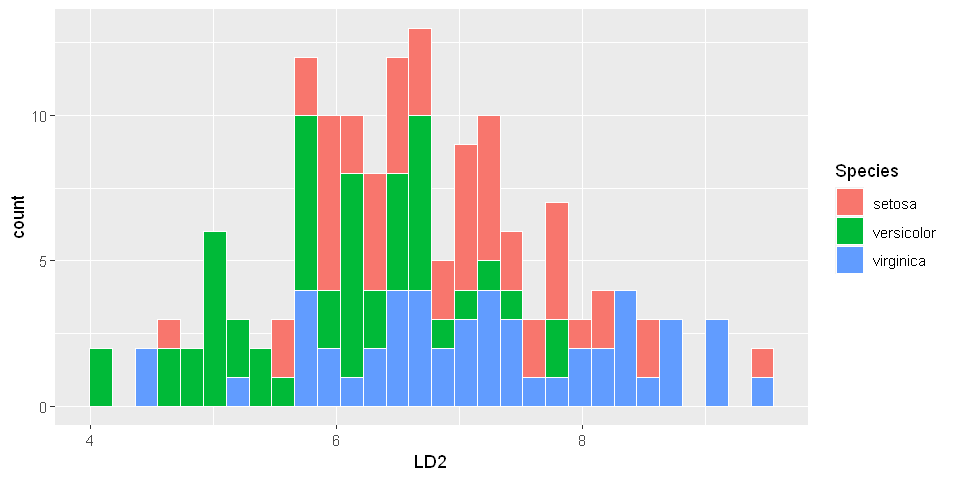

In [83]:
# Convert data points to new coordinate
ld1 <- as.matrix(iris[, -5]) %*% md_lda$scaling[, 1]  # 1st axis
ld2 <- as.matrix(iris[, -5]) %*% md_lda$scaling[, 2]  # 2nd axis

# Plot
iris_lda <- data.frame(LD1=ld1, LD2=ld2, Species=iris$Species)

options(repr.plot.width=8, repr.plot.height=4)
ggplot(data=iris_lda, aes(x=LD1, fill=Species)) + 
  geom_histogram(colour='white')

ggplot(data=iris_lda, aes(x=LD2, fill=Species)) + 
  geom_histogram(colour='white') 

In [84]:
# Make some prediction
lda_pred <- predict(md_lda)
head(lda_pred$posterior)

,setosa,versicolor,virginica
1,1,3.896358e-22,2.611168e-42
2,1,7.217970e-18,5.042143e-37
3,1,1.463849e-19,4.675932e-39
4,1,1.268536e-16,3.566610e-35
5,1,1.637387e-22,1.082605e-42
6,1,3.883282e-21,4.566540e-40


#### 4.2. Quadratic Discriminant Analysis (QDA)

In [86]:
# Fit QDA model
library(MASS)
md_qda <- qda(Species ~ ., data=iris)
md_qda

Call:
qda(Species ~ ., data = iris)

Prior probabilities of groups:
    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

Group means:
           Sepal.Length Sepal.Width Petal.Length Petal.Width
setosa            5.006       3.428        1.462       0.246
versicolor        5.936       2.770        4.260       1.326
virginica         6.588       2.974        5.552       2.026

In [87]:
# Make some prediction
qda_pred <- predict(md_qda)
head(qda_pred$posterior)

,setosa,versicolor,virginica
1,1,4.918517e-26,2.981541e-41
2,1,7.655808e-19,1.311032e-34
3,1,1.552279e-21,3.380440e-36
4,1,8.300396e-19,8.541858e-32
5,1,3.365614e-27,2.010147e-41
6,1,1.472533e-26,1.271928e-40


## Lab: Logistic Regression, LDA, QDA and KNN

1. The Stock Market Data 2001-2005
2. Caravan Insurance Data
3. Student Performance Data

**Other multinomial datasets to practice:**
1. Soybean (Large) Data Set: http://archive.ics.uci.edu/ml/datasets/Soybean+%28Large%29
2. Glass Identification Data Set: https://archive.ics.uci.edu/ml/datasets/Glass+Identification
3. Car Evaluation Data Set: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### Lab 1: The S&P Index Data 2001-2005

#### 1.1. Load and explore the stock market data

In [88]:
# Require libraries
require(ISLR)  # Stock data sets
require(gridExtra)  # Arrange plot

# Load and explore the stock market data
# Year      : The year of stock data
# Lag1-5    : Percentage return for 1-5 days previous
# Volume    : Volume of shares traded (number of daily shares traded in billions)
# Today     : Percentage return for today
# Direction : A factor with levels Down and Up indicating whether the market had a positive or negative return on a given day
str(Smarket)

'data.frame':	1250 obs. of  9 variables:
 $ Year     : num  2001 2001 2001 2001 2001 ...
 $ Lag1     : num  0.381 0.959 1.032 -0.623 0.614 ...
 $ Lag2     : num  -0.192 0.381 0.959 1.032 -0.623 ...
 $ Lag3     : num  -2.624 -0.192 0.381 0.959 1.032 ...
 $ Lag4     : num  -1.055 -2.624 -0.192 0.381 0.959 ...
 $ Lag5     : num  5.01 -1.055 -2.624 -0.192 0.381 ...
 $ Volume   : num  1.19 1.3 1.41 1.28 1.21 ...
 $ Today    : num  0.959 1.032 -0.623 0.614 0.213 ...
 $ Direction: Factor w/ 2 levels "Down","Up": 2 2 1 2 2 2 1 2 2 2 ...


In [89]:
# Show variables description
help(Smarket)

In [90]:
summary(Smarket)

      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 

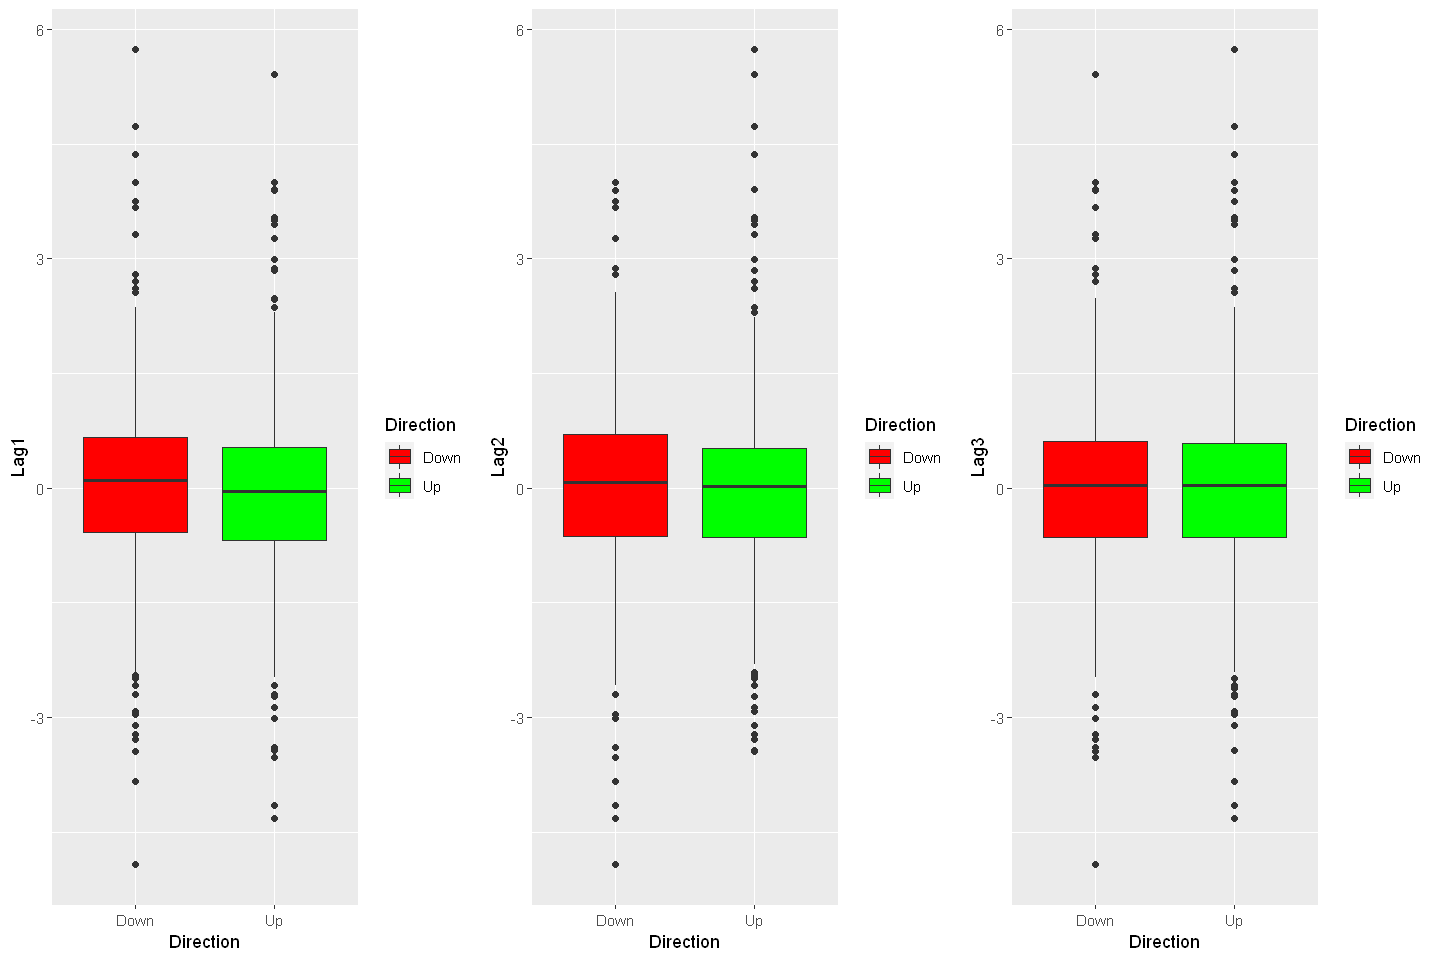

In [93]:
# Visualize the data
options(repr.plot.width=12, repr.plot.height=8)

p1 <- ggplot(Smarket[, c('Lag1', 'Lag2', 'Lag3', 'Direction')], aes(x=Direction, y=Lag1, fill=Direction)) +
  geom_boxplot() +
  scale_fill_manual(values = c("red", "green"))
p2 <- ggplot(Smarket[, c('Lag1', 'Lag2', 'Lag3', 'Direction')], aes(x=Direction, y=Lag2, fill=Direction)) +
  geom_boxplot() +
  scale_fill_manual(values = c("red", "green"))
p3 <- ggplot(Smarket[, c('Lag1', 'Lag2', 'Lag3', 'Direction')], aes(x=Direction, y=Lag3, fill=Direction)) +
  geom_boxplot() +
  scale_fill_manual(values = c("red", "green"))

grid.arrange(p1, p2, p3, nrow=1)

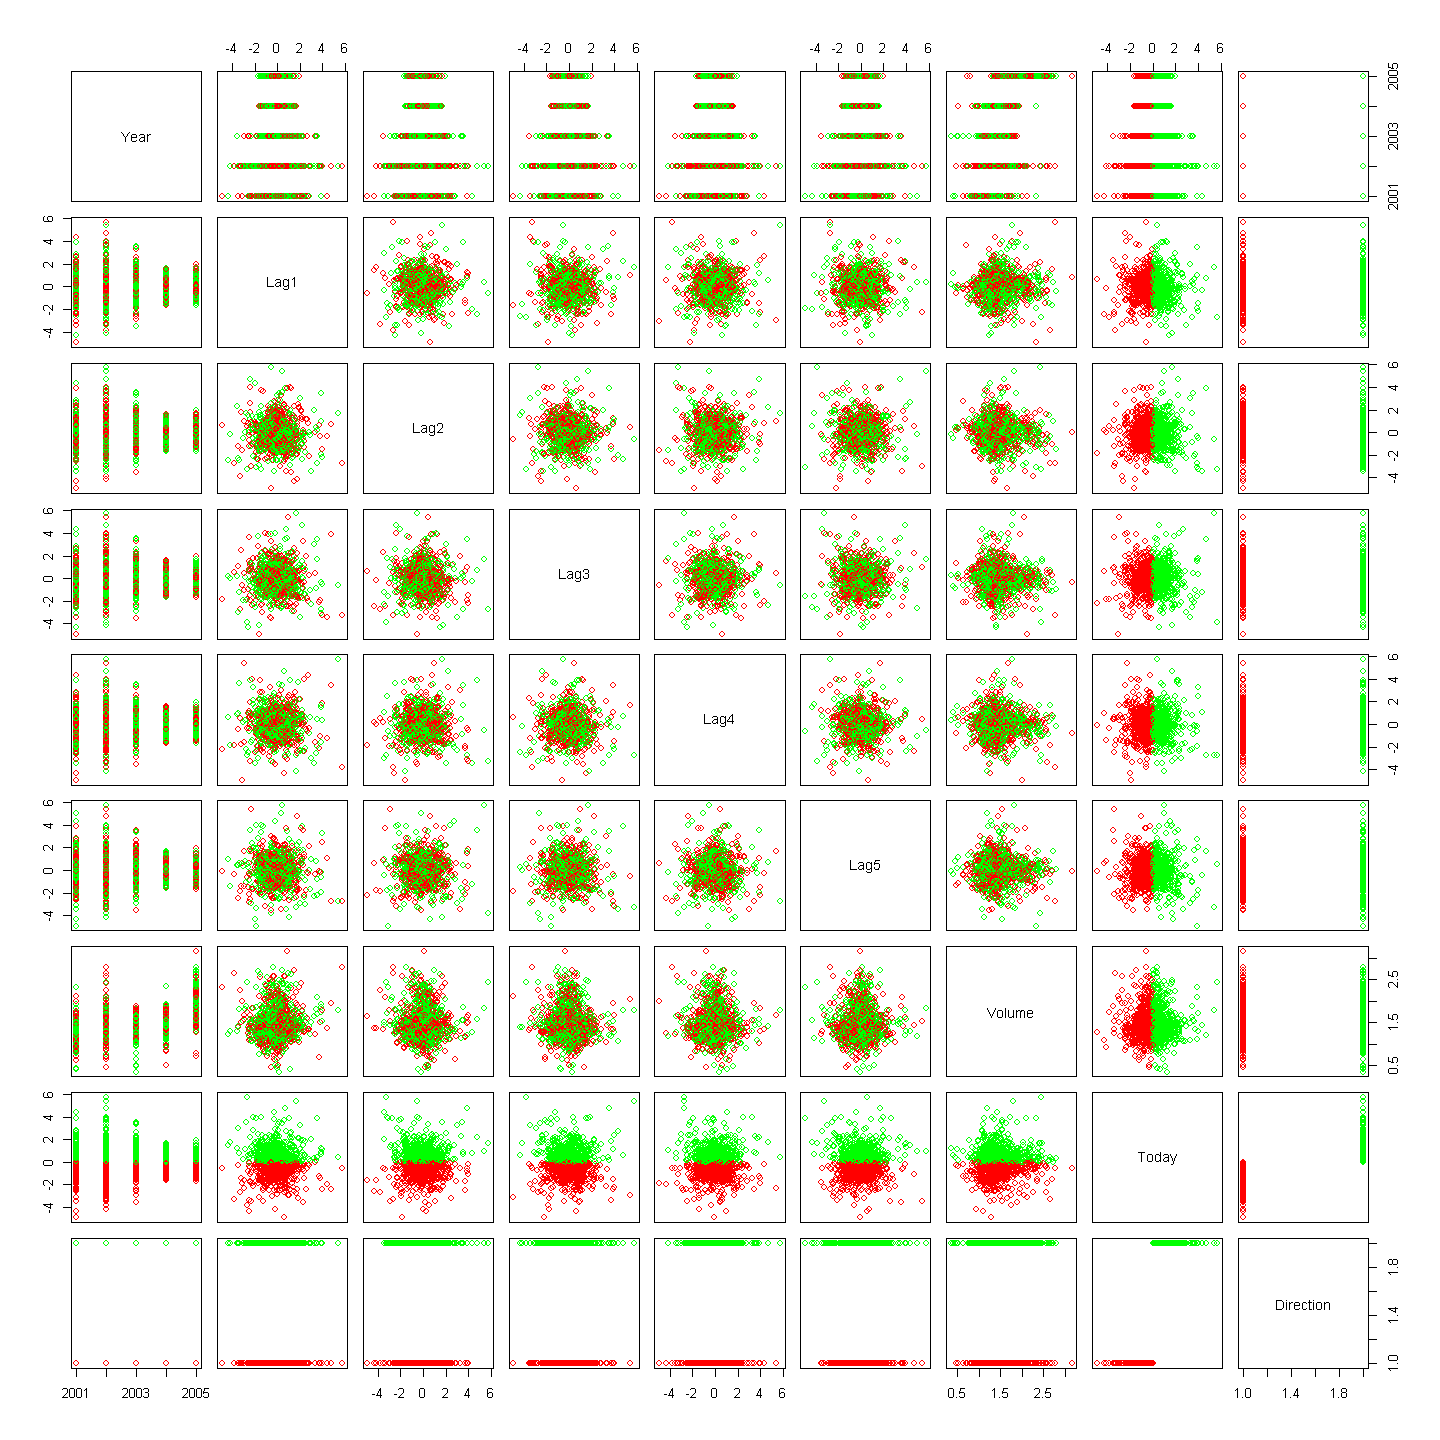

In [94]:
# Pair plot
options(repr.plot.width=12, repr.plot.height=12)
cols <- rep('green', nrow(Smarket))  # Up
cols[Smarket$Direction == 'Down'] <- 'red'  # Down
pairs(Smarket, col=cols)

In [95]:
# Correlation matrix
cor(Smarket[, -9])

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,0.029699649,0.030596422,0.033194581,0.035688718,0.029787995,0.53900647,0.030095229
Lag1,0.02969965,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,0.03059642,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,0.03319458,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,0.03568872,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,0.02978799,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.53900647,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,0.03009523,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000


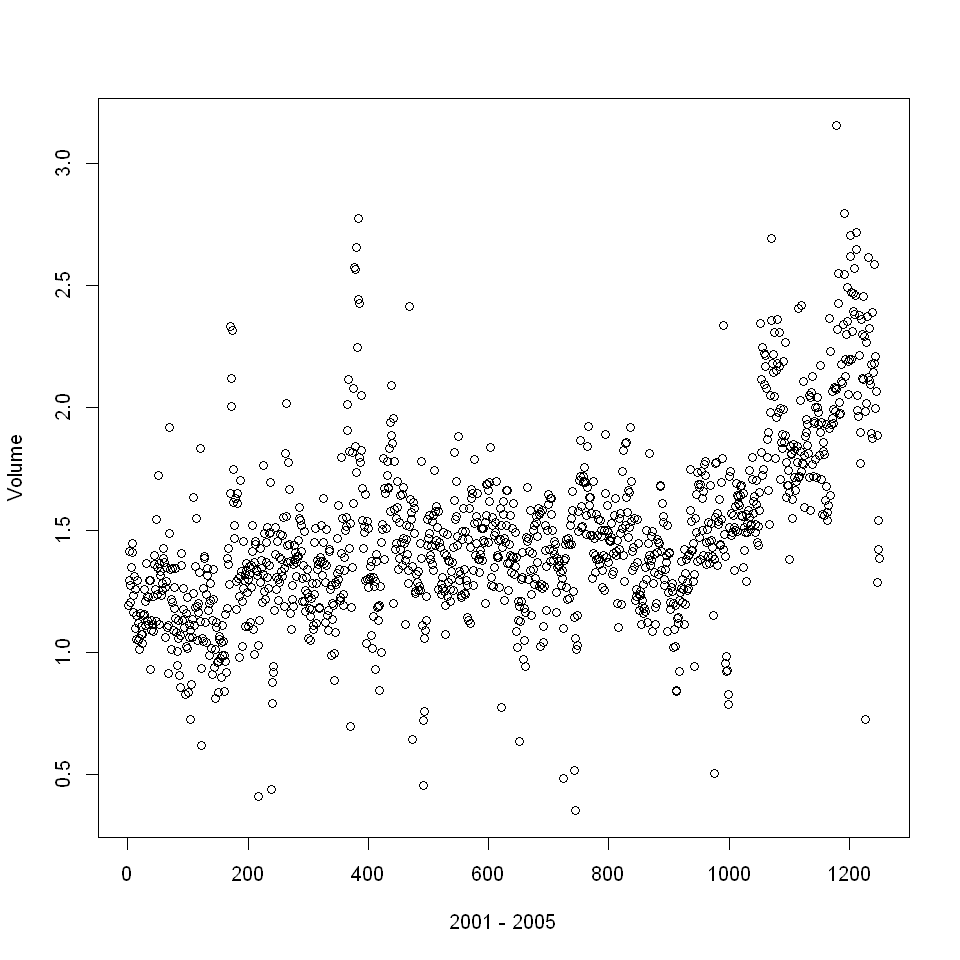

In [96]:
# Stock trading volume from 2001 to 2005
options(repr.plot.width=8, repr.plot.height=8)
plot(Smarket$Volume,
     xlab='2001 - 2005', ylab='Volume')

#### 1.2. Logistic Regression

In [98]:
# Separate data to train and test
stock_train <- Smarket[Smarket$Year < 2005, ]
stock_test <- Smarket[Smarket$Year == 2005, ]

In [99]:
# Fit Logistic Regression model
md_logreg <- glm(Direction ∼ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
                 data=stock_train, family=binomial)
summary(md_logreg)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = stock_train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.302  -1.190   1.079   1.160   1.350  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.191213   0.333690   0.573    0.567
Lag1        -0.054178   0.051785  -1.046    0.295
Lag2        -0.045805   0.051797  -0.884    0.377
Lag3         0.007200   0.051644   0.139    0.889
Lag4         0.006441   0.051706   0.125    0.901
Lag5        -0.004223   0.051138  -0.083    0.934
Volume      -0.116257   0.239618  -0.485    0.628

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.1  on 991  degrees of freedom
AIC: 1395.1

Number of Fisher Scoring iterations: 3


In [100]:
# Re-fit Logistic Regression model with 2 best predictors
md_logreg <- glm(Direction ∼ Lag1 + Lag2,
                 data=stock_train, family=binomial)
summary(md_logreg)


Call:
glm(formula = Direction ~ Lag1 + Lag2, family = binomial, data = stock_train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.345  -1.188   1.074   1.164   1.326  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.03222    0.06338   0.508    0.611
Lag1        -0.05562    0.05171  -1.076    0.282
Lag2        -0.04449    0.05166  -0.861    0.389

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.4  on 995  degrees of freedom
AIC: 1387.4

Number of Fisher Scoring iterations: 3


In [101]:
# Make prediction on both train and test data
pred_train_prob <- predict(md_logreg, newdata=stock_train, type='response')
head(pred_train_prob)

pred_test_prob <- predict(md_logreg, newdata=stock_test, type='response')
head(pred_test_prob)

1         2         3         4         5         6 
0.5048917 0.4904830 0.4830449 0.5052396 0.5064450 0.4982638

999      1000      1001      1002      1003      1004 
0.5098275 0.5208237 0.5332635 0.5260574 0.5072103 0.5061388

In [102]:
# Evaluation model on train
threshold <- 0.5  # Decision threshold
pred_train <- rep('Down', length(pred_train_prob))
pred_train[pred_train_prob > threshold] <- 'Up'

# Confusion matrix
print('Confusion matrix:')
table(pred_train, stock_train$Direction)

# Accuracy and error rate
acc <- mean(pred_train == stock_train$Direction)
err_rate <- 1 - acc
print(paste('Accuracy =', round(acc, 2), '%'))
print(paste('Error =', round(err_rate, 2), '%'))

# AUC
pred_roc <- pROC::roc(as.numeric(pred_train_prob), as.numeric(stock_train$Direction == "Up"))
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


          
pred_train Down  Up
      Down  168 160
      Up    323 347

[1] "Accuracy = 0.52 %"
[1] "Error = 0.48 %"


Warning message in roc.default(as.numeric(pred_train_prob), as.numeric(stock_train$Direction == :
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 0.414916857071351, case = 0.415661445486411

Setting direction: controls < cases



[1] "AUC = 0.5"


In [103]:
# Evaluation model on test
threshold <- 0.5  # Decision threshold
pred_test <- rep('Down', length(pred_test_prob))
pred_test[pred_test_prob > threshold] <- 'Up'

# Confusion matrix
print('Confusion matrix:')
table(pred_test, stock_test$Direction)

# Accuracy and error rate
acc <- mean(pred_test == stock_test$Direction)
err_rate <- 1 - acc
print(paste('Accuracy =', round(acc, 2), '%'))
print(paste('Error =', round(err_rate, 2), '%'))

# AUC
pred_roc <- pROC::roc(as.numeric(pred_test_prob), as.numeric(stock_test$Direction == "Up"))
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
pred_test Down  Up
     Down   35  35
     Up     76 106

[1] "Accuracy = 0.56 %"
[1] "Error = 0.44 %"


Warning message in roc.default(as.numeric(pred_test_prob), as.numeric(stock_test$Direction == :
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 0.479675148042168, case = 0.483037293021864

Setting direction: controls < cases



[1] "AUC = 0.5"


#### 1.3. Linear Discriminant Analysis (LDA)

In [104]:
# Fit the LDA model with 2 best predictors from LogRes model
library(MASS)
md_lda <- lda(Direction ~ Lag1 + Lag2, data=stock_train)
md_lda

Call:
lda(Direction ~ Lag1 + Lag2, data = stock_train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

In [66]:
# options(repr.plot.width=4, repr.plot.height=8)
# plot(md_lda)

In [105]:
# Predict and evaluate on test data
lda_pred <- predict(md_lda, newdata=stock_test)
head(lda_pred$class)
head(lda_pred$posterior)

# Confusion matrix
print('Confusion matrix:')
table(lda_pred$class, stock_test$Direction)

# Accuracy
acc <- mean(lda_pred$class == stock_test$Direction)
print(paste('Accuracy =', round(acc, 2), '%'))

[1] Up Up Up Up Up Up
Levels: Down Up

,Down,Up
999,0.4901792,0.5098208
1000,0.4792185,0.5207815
1001,0.4668185,0.5331815
1002,0.4740011,0.5259989
1003,0.4927877,0.5072123
1004,0.4938562,0.5061438


[1] "Confusion matrix:"


      
       Down  Up
  Down   35  35
  Up     76 106

[1] "Accuracy = 0.56 %"


#### 1.4. Quadratic Discriminant Analysis (QDA)

In [106]:
# Fit the QDA model on train set with 2 best predictors
md_qda <- qda(Direction ~ Lag1 + Lag2, data=stock_train)
md_qda

Call:
qda(Direction ~ Lag1 + Lag2, data = stock_train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

In [107]:
# Predict and evaluate on test data
qda_pred <- predict(md_qda, newdata=stock_test)
head(qda_pred$class)
head(qda_pred$posterior)

# Confusion matrix
print('Confusion matrix:')
table(qda_pred$class, stock_test$Direction)

# Accuracy
acc <- mean(qda_pred$class == stock_test$Direction)
print(paste('Accuracy =', round(acc, 2), '%'))

[1] Up Up Up Up Up Up
Levels: Down Up

,Down,Up
999,0.4873243,0.5126757
1000,0.4759011,0.5240989
1001,0.4636911,0.5363089
1002,0.4739253,0.5260747
1003,0.4903426,0.5096574
1004,0.4913561,0.5086439


[1] "Confusion matrix:"


      
       Down  Up
  Down   30  20
  Up     81 121

[1] "Accuracy = 0.6 %"


#### 1.5. K-Nearest Neighbors (KNN)

In [108]:
# Fit the KNN model with the train set using 2 best predictors
library(class)

# k = 1
set.seed(123)
knn1_pred <- knn(train=stock_train[, c('Lag1', 'Lag2')],
                 test=stock_test[, c('Lag1', 'Lag2')],
                 cl=stock_train$Direction,
                 k=1)

# Confusion matrix
print('Confusion matrix:')
table(knn1_pred, stock_test$Direction)

# Accuracy
acc <- mean(knn1_pred == stock_test$Direction)
print(paste('Accuracy =', round(acc, 2), '%'))

[1] "Confusion matrix:"


         
knn1_pred Down Up
     Down   43 58
     Up     68 83

[1] "Accuracy = 0.5 %"


In [109]:
# k = 3
set.seed(123)
knn3_pred <- knn(train=stock_train[, c('Lag1', 'Lag2')],
                 test=stock_test[, c('Lag1', 'Lag2')],
                 cl=stock_train$Direction,
                 k=3)

# Confusion matrix
print('Confusion matrix:')
table(knn3_pred, stock_test$Direction)

# Accuracy
acc <- mean(knn3_pred == stock_test$Direction)
print(paste('Accuracy =', round(acc, 2), '%'))

[1] "Confusion matrix:"


         
knn3_pred Down Up
     Down   48 55
     Up     63 86

[1] "Accuracy = 0.53 %"


### Lab 2: Caravan Insurance Data

In [110]:
# Load data, 58 predictors, demographics characters
library(ISLR)

# The Insurance Company (TIC) Benchmark
# Variables 1-43         : sociodemographic data
# Variables 44-86        : product ownership
# Variable 86 (Purchase) : whether the customer purchased a caravan insurance policy
str(Caravan)

'data.frame':	5822 obs. of  86 variables:
 $ MOSTYPE : num  33 37 37 9 40 23 39 33 33 11 ...
 $ MAANTHUI: num  1 1 1 1 1 1 2 1 1 2 ...
 $ MGEMOMV : num  3 2 2 3 4 2 3 2 2 3 ...
 $ MGEMLEEF: num  2 2 2 3 2 1 2 3 4 3 ...
 $ MOSHOOFD: num  8 8 8 3 10 5 9 8 8 3 ...
 $ MGODRK  : num  0 1 0 2 1 0 2 0 0 3 ...
 $ MGODPR  : num  5 4 4 3 4 5 2 7 1 5 ...
 $ MGODOV  : num  1 1 2 2 1 0 0 0 3 0 ...
 $ MGODGE  : num  3 4 4 4 4 5 5 2 6 2 ...
 $ MRELGE  : num  7 6 3 5 7 0 7 7 6 7 ...
 $ MRELSA  : num  0 2 2 2 1 6 2 2 0 0 ...
 $ MRELOV  : num  2 2 4 2 2 3 0 0 3 2 ...
 $ MFALLEEN: num  1 0 4 2 2 3 0 0 3 2 ...
 $ MFGEKIND: num  2 4 4 3 4 5 3 5 3 2 ...
 $ MFWEKIND: num  6 5 2 4 4 2 6 4 3 6 ...
 $ MOPLHOOG: num  1 0 0 3 5 0 0 0 0 0 ...
 $ MOPLMIDD: num  2 5 5 4 4 5 4 3 1 4 ...
 $ MOPLLAAG: num  7 4 4 2 0 4 5 6 8 5 ...
 $ MBERHOOG: num  1 0 0 4 0 2 0 2 1 2 ...
 $ MBERZELF: num  0 0 0 0 5 0 0 0 1 0 ...
 $ MBERBOER: num  1 0 0 0 4 0 0 0 0 0 ...
 $ MBERMIDD: num  2 5 7 3 0 4 4 2 1 3 ...
 $ MBERARBG: num  5 0 0 

In [111]:
help(Caravan)

In [112]:
# Response ratio
table(Caravan$Purchase)/nrow(Caravan)


        No        Yes 
0.94022673 0.05977327 

In [113]:
# Data processing, scale data for KNN
Caravan_scaled <- data.frame(scale(Caravan[, -86]))  # Standardize
Caravan_scaled['Purchase'] <- Caravan[, 'Purchase']  # Add target variable

mean(Caravan_scaled[, 1])  # Mean = 0
var(Caravan_scaled[, 1])  # Variance = Standard deviation = 1
head(Caravan_scaled)

[1] -7.025576e-17

[1] 1

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,⋯,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.68084775,-0.2725565,0.4066617,-1.21685949,0.7793384,-0.6942510,0.2174254,-0.06870474,-0.1618019,0.42763309,⋯,-0.07315883,-0.08104764,-0.05991487,0.764905,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No
2,0.99221162,-0.2725565,-0.8594262,-1.21685949,0.7793384,0.3025256,-0.3653787,-0.06870474,0.4641188,-0.09606902,⋯,-0.07315883,-0.08104764,-0.05991487,0.764905,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No
3,0.99221162,-0.2725565,-0.8594262,-1.21685949,0.7793384,-0.6942510,-0.3653787,0.91409379,0.4641188,-1.66717535,⋯,-0.07315883,-0.08104764,-0.05991487,0.764905,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No
4,-1.18733547,-0.2725565,0.4066617,0.01075374,-0.9708962,1.2993023,-0.9481828,0.91409379,0.4641188,-0.61977113,⋯,-0.07315883,-0.08104764,-0.05991487,0.764905,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No
5,1.22573452,-0.2725565,1.6727497,-1.21685949,1.4794323,0.3025256,-0.3653787,-0.06870474,0.4641188,0.42763309,⋯,-0.07315883,-0.08104764,-0.05991487,0.764905,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No
6,-0.09756193,-0.2725565,-0.8594262,-2.44447272,-0.2708024,-0.6942510,0.2174254,-1.05150327,1.0900394,-3.23828168,⋯,-0.07315883,-0.08104764,-0.05991487,-1.014271,-0.02270383,-0.07364394,-0.1506075,-0.08734022,-0.1188063,No


In [114]:
# Train test spliting
set.seed(123)
train_idx <- createDataPartition(Caravan[, 'Purchase'], p=.7, list=FALSE)

# Train dataset
train <- Caravan[train_idx, ]
train_scaled <- Caravan_scaled[train_idx, ]

# Test dataset
test <- Caravan[-train_idx, ]
test_scaled <- Caravan_scaled[-train_idx, ]

In [115]:
# Fit KNN model k=1
pred_knn <- knn(train=train_scaled[, -86], test=test_scaled[, -86], cl=train_scaled[, 86], k=1)

# Evaluation
table(pred_knn, test$Purchase)
acc <- mean(pred_knn == test_scaled$Purchase)
TP <- table(pred_knn, test_scaled$Purchase)[2, 2]
TN <- table(pred_knn, test_scaled$Purchase)[1, 1]
FP <- table(pred_knn, test_scaled$Purchase)[2, 1]
FN <- table(pred_knn, test_scaled$Purchase)[1, 2]

print(paste('Accuracy =', round(acc, 2)))
print(paste('Precision =', round(TP / (TP + FP), 2)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 2)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 2)))

        
pred_knn   No  Yes
     No  1548   90
     Yes   94   14

[1] "Accuracy = 0.89"
[1] "Precision = 0.13"
[1] "Sensitivity (TPR) = 0.13"
[1] "Specificity (TNR) = 0.94"


In [116]:
# Fit KNN model k=2
pred_knn <- knn(train=train_scaled[, -86], test=test_scaled[, -86], cl=train_scaled[, 86], k=2)

# Evaluation
table(pred_knn, test_scaled$Purchase)
acc <- mean(pred_knn == test$Purchase)
TP <- table(pred_knn, test_scaled$Purchase)[2, 2]
TN <- table(pred_knn, test_scaled$Purchase)[1, 1]
FP <- table(pred_knn, test_scaled$Purchase)[2, 1]
FN <- table(pred_knn, test_scaled$Purchase)[1, 2]

print(paste('Accuracy =', round(acc, 2)))
print(paste('Precision =', round(TP / (TP + FP), 2)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 2)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 2)))

        
pred_knn   No  Yes
     No  1536   90
     Yes  106   14

[1] "Accuracy = 0.89"
[1] "Precision = 0.12"
[1] "Sensitivity (TPR) = 0.13"
[1] "Specificity (TNR) = 0.94"


In [117]:
# Fit Logistic Regression model
md_logreg <- glm(Purchase ~ ., data=train, family=binomial)

# Make prediction
pred_logreg <- predict(md_logreg, newdata=test, type='response')
head(pred_logreg)

# Decision threshold = 0.5
threshold <- 0.5
pred <- rep('No', nrow(test))
pred[pred_logreg > threshold] <- 'Yes'

# Evaluation
table(pred, test$Purchase)
acc <- mean(pred == test$Purchase)
TP <- table(pred, test$Purchase)[2, 2]
TN <- table(pred, test$Purchase)[1, 1]
FP <- table(pred, test$Purchase)[2, 1]
FN <- table(pred, test$Purchase)[1, 2]

print(paste('Accuracy =', round(acc, 2)))
print(paste('Precision =', round(TP / (TP + FP), 2)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 2)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 2)))

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


3           4           6           8           9          11 
0.058176373 0.056375293 0.011272348 0.009468564 0.027184732 0.115928523

     
pred    No  Yes
  No  1632  101
  Yes   10    3

[1] "Accuracy = 0.94"
[1] "Precision = 0.23"
[1] "Sensitivity (TPR) = 0.03"
[1] "Specificity (TNR) = 0.99"


In [118]:
# Decision threshold = 0.25
threshold <- 0.25
pred <- rep('No', nrow(test))
pred[pred_logreg > threshold] <- 'Yes'

# Evaluation
table(pred, test$Purchase)
acc <- mean(pred == test$Purchase)
TP <- table(pred, test$Purchase)[2, 2]
TN <- table(pred, test$Purchase)[1, 1]
FP <- table(pred, test$Purchase)[2, 1]
FN <- table(pred, test$Purchase)[1, 2]

print(paste('Accuracy =', round(acc, 2)))
print(paste('Precision =', round(TP / (TP + FP), 2)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 2)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 2)))

     
pred    No  Yes
  No  1579   88
  Yes   63   16

[1] "Accuracy = 0.91"
[1] "Precision = 0.2"
[1] "Sensitivity (TPR) = 0.15"
[1] "Specificity (TNR) = 0.96"


### Lab 3: Student Performance Data

#### 3.1. Data exploration

In [1]:
# Required library
library(mlr)   # ML framework
require(kknn)  # kNN
require(MASS)  # LDA, QDA
require(nnet)  # Multinomial LogRes

Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).

Loading required package: kknn

Loading required package: MASS

Loading required package: nnet



In [123]:
# Import data
student <- read.csv('./data/student/student-mat.csv', sep=';')
str(student)

'data.frame':	395 obs. of  33 variables:
 $ school    : chr  "GP" "GP" "GP" "GP" ...
 $ sex       : chr  "F" "F" "F" "F" ...
 $ age       : int  18 17 15 15 16 16 16 17 15 15 ...
 $ address   : chr  "U" "U" "U" "U" ...
 $ famsize   : chr  "GT3" "GT3" "LE3" "GT3" ...
 $ Pstatus   : chr  "A" "T" "T" "T" ...
 $ Medu      : int  4 1 1 4 3 4 2 4 3 3 ...
 $ Fedu      : int  4 1 1 2 3 3 2 4 2 4 ...
 $ Mjob      : chr  "at_home" "at_home" "at_home" "health" ...
 $ Fjob      : chr  "teacher" "other" "other" "services" ...
 $ reason    : chr  "course" "course" "other" "home" ...
 $ guardian  : chr  "mother" "father" "mother" "mother" ...
 $ traveltime: int  2 1 1 1 1 1 1 2 1 1 ...
 $ studytime : int  2 2 2 3 2 2 2 2 2 2 ...
 $ failures  : int  0 0 3 0 0 0 0 0 0 0 ...
 $ schoolsup : chr  "yes" "no" "yes" "no" ...
 $ famsup    : chr  "no" "yes" "no" "yes" ...
 $ paid      : chr  "no" "no" "yes" "yes" ...
 $ activities: chr  "no" "no" "no" "yes" ...
 $ nursery   : chr  "yes" "no" "yes" "yes" ...
 $

In [124]:
# Check NA
apply(is.na(student), 2, sum)

school        sex        age    address    famsize    Pstatus       Medu 
         0          0          0          0          0          0          0 
      Fedu       Mjob       Fjob     reason   guardian traveltime  studytime 
         0          0          0          0          0          0          0 
  failures  schoolsup     famsup       paid activities    nursery     higher 
         0          0          0          0          0          0          0 
  internet   romantic     famrel   freetime      goout       Dalc       Walc 
         0          0          0          0          0          0          0 
    health   absences         G1         G2         G3 
         0          0          0          0          0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.00   11.00   10.42   14.00   20.00 

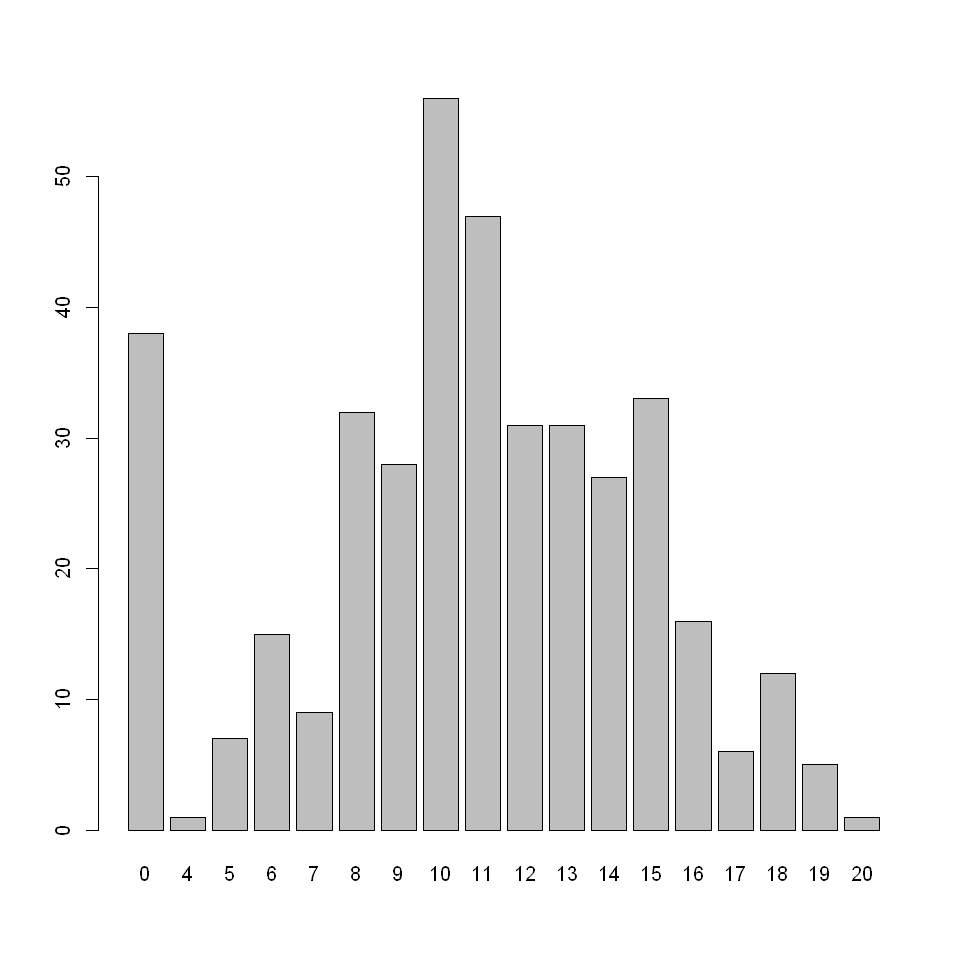

In [125]:
# Check target variable
summary(student$G3)

options(repr.plot.width=8, repr.plot.height=8)
barplot(table(student$G3))

#### 3.2. Binomial classification

In [126]:
# Bin target variable into 2 groups: pass = Y/N
student$pass <- 'N'
student[student$G3 >= 10, 'pass'] <- 'Y'

table(student$pass)
table(student$pass)/nrow(student)


  N   Y 
130 265 


        N         Y 
0.3291139 0.6708861 

In [127]:
# Drop the previous target column
student$G3 <- NULL

#### Pre-process data

In [128]:
# Get list of categorical variables
var_list <- names(student[, 1:(ncol(student)-1)])
cat_list <- var_list[sapply(student[, var_list], class) == 'character']
cat_list

[1] "school"     "sex"        "address"    "famsize"    "Pstatus"   
 [6] "Mjob"       "Fjob"       "reason"     "guardian"   "schoolsup" 
[11] "famsup"     "paid"       "activities" "nursery"    "higher"    
[16] "internet"   "romantic"

In [129]:
# Convert categorical variables to dummy variables
dummy_list <- list()
for (v in cat_list) {
    # Create dummy variables
    tmp <- dummy(v, data=student, sep="_", drop=TRUE)
    # Drop the 1st column
    tmp <- tmp[, 2:ncol(tmp), drop=FALSE]
    # Store the results
    dummy_list[[length(dummy_list)+1]] <- tmp
}

# Combine the dummy variables
dummy_df <- do.call(cbind, dummy_list)

# Add the dummy variables to the data frame
student <- cbind(student, dummy_df)

# Drop the original variable
student <- student[, !(names(student) %in% cat_list)]

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts ar

In [130]:
# Show the final basetable
head(student)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,⋯,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,18,4,4,2,2,0,4,3,4,1,⋯,1,0,1,0,0,0,1,1,0,0
2,17,1,1,1,2,0,5,3,3,1,⋯,0,0,0,1,0,0,0,1,1,0
3,15,1,1,1,2,3,4,3,2,2,⋯,1,0,1,0,1,0,1,1,1,0
4,15,4,2,1,3,0,3,2,2,1,⋯,1,0,0,1,1,1,1,1,1,1
5,16,3,3,1,2,0,4,3,2,1,⋯,0,0,0,1,1,0,1,1,0,0
6,16,4,3,1,2,0,5,4,2,1,⋯,1,0,0,1,1,1,1,1,1,0


#### Test Logistic Regression (LogRes) model, 10-fold CV

In [106]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_logreg <- makeLearner("classif.logreg", predict.type="prob", fix.factors.prediction=T)

# Define the model
task_logreg <- makeClassifTask(id="student", data=student, target="pass")

# Run the k-fold CV
resample(lnr_logreg, task_logreg, rdesc, measures=list(mlr::auc))

Resampling: cross-validation

Measures:             auc       

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 1:    0.9444444 

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 2:    0.8375000 

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 3:    0.9600000 

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 4:    0.8681319 

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 5:    0.8842593 

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
[Resample] iter 6:    0.7666667 

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities nu

Resample Result
Task: student
Learner: classif.logreg
Aggr perf: auc.test.mean=0.8985061
Runtime: 0.403921

**Test Linear Discriminant Analysis (LDA) model, 10-fold CV**

In [107]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_lda <- makeLearner("classif.lda", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="pass")

# Run the k-fold CV
resample(lnr_lda, task_logreg, rdesc, measures=list(mlr::auc))

Resampling: cross-validation

Measures:             auc       

[Resample] iter 1:    0.9342105 

[Resample] iter 2:    0.9082840 

[Resample] iter 3:    0.9571429 

[Resample] iter 4:    0.9804688 

[Resample] iter 5:    0.9780220 

[Resample] iter 6:    0.8701299 

[Resample] iter 7:    0.9914530 

[Resample] iter 8:    0.9544160 

[Resample] iter 9:    0.9829060 

[Resample] iter 10:   0.9074074 




Aggregated Result: auc.test.mean=0.9464440






Resample Result
Task: student
Learner: classif.lda
Aggr perf: auc.test.mean=0.9464440
Runtime: 0.287742

**Test Quadratic Discriminant Analysis (QDA) model, 10-fold CV**

In [108]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_qda <- makeLearner("classif.qda", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="pass")

# Run the k-fold CV
resample(lnr_qda, task_logreg, rdesc, measures=list(mlr::auc))

Resampling: cross-validation

Measures:             auc       

[Resample] iter 1:    0.9104938 

[Resample] iter 2:    0.8066667 

[Resample] iter 3:    0.8724138 

[Resample] iter 4:    0.9493333 

[Resample] iter 5:    0.7633136 

[Resample] iter 6:    0.8020833 

[Resample] iter 7:    0.8302469 

[Resample] iter 8:    0.9085714 

[Resample] iter 9:    0.8213333 

[Resample] iter 10:   0.7635328 




Aggregated Result: auc.test.mean=0.8427989






Resample Result
Task: student
Learner: classif.qda
Aggr perf: auc.test.mean=0.8427989
Runtime: 0.226395

**Test k-Nearest Neighbor (kNN) model, k=1, 10-fold CV**

In [109]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_knn <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T, k=1)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="pass")

# Run the k-fold CV
resample(lnr_knn, task_logreg, rdesc, measures=list(mlr::auc))

Resampling: cross-validation

Measures:             auc       

[Resample] iter 1:    0.6136364 

[Resample] iter 2:    0.6473354 

[Resample] iter 3:    0.4531250 

[Resample] iter 4:    0.6942935 

[Resample] iter 5:    0.6342105 

[Resample] iter 6:    0.6333333 

[Resample] iter 7:    0.5000000 

[Resample] iter 8:    0.5887097 

[Resample] iter 9:    0.6487455 

[Resample] iter 10:   0.7500000 




Aggregated Result: auc.test.mean=0.6163389






Resample Result
Task: student
Learner: classif.kknn
Aggr perf: auc.test.mean=0.6163389
Runtime: 0.177523

**Test k-Nearest Neighbor (kNN) model, k=100, 10-fold CV**

In [110]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_knn <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T, k=100)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="pass")

# Run the k-fold CV
resample(lnr_knn, task_logreg, rdesc, measures=list(mlr::auc))

Resampling: cross-validation

Measures:             auc       

[Resample] iter 1:    0.8717949 

[Resample] iter 2:    0.9829060 

[Resample] iter 3:    0.9142857 

[Resample] iter 4:    0.9202279 

[Resample] iter 5:    0.9938272 

[Resample] iter 6:    0.8996865 

[Resample] iter 7:    0.8858025 

[Resample] iter 8:    0.8714286 

[Resample] iter 9:    0.7750000 

[Resample] iter 10:   0.9829060 




Aggregated Result: auc.test.mean=0.9097865






Resample Result
Task: student
Learner: classif.kknn
Aggr perf: auc.test.mean=0.9097865
Runtime: 0.2015

#### 3.3. Multinomial classification

In [111]:
require(nnet)  # One-vs-All Logistic Regression

In [131]:
# Read the data (again)
student_raw <- read.csv('./data/student/student-mat.csv', sep=';')

# Bin target variable into group
# Refs: http://www.canada.campusfrance.org/en/faq/french-grading-system-same-canadian-system

student_raw$final_grade <- 'F'
student_raw[student_raw$G3 >= 10 & student_raw$G3 <= 11.9, 'final_grade'] <- 'C'
student_raw[student_raw$G3 >= 12 & student_raw$G3 <= 12.9, 'final_grade'] <- 'B'
student_raw[student_raw$G3 >= 13 & student_raw$G3 <= 13.9, 'final_grade'] <- 'B+'
student_raw[student_raw$G3 >= 14 & student_raw$G3 <= 15.9, 'final_grade'] <- 'A-'
student_raw[student_raw$G3 >= 16 & student_raw$G3 <= 20, 'final_grade'] <- 'A'

# Print out the class distribution (in percentage)
table(student_raw$final_grade)/nrow(student) * 100

# Assign the new target variable to the basetable
student$final_grade <- student_raw$final_grade
student$pass <- NULL


        A        A-         B        B+         C         F 
10.126582 15.189873  7.848101  7.848101 26.075949 32.911392 

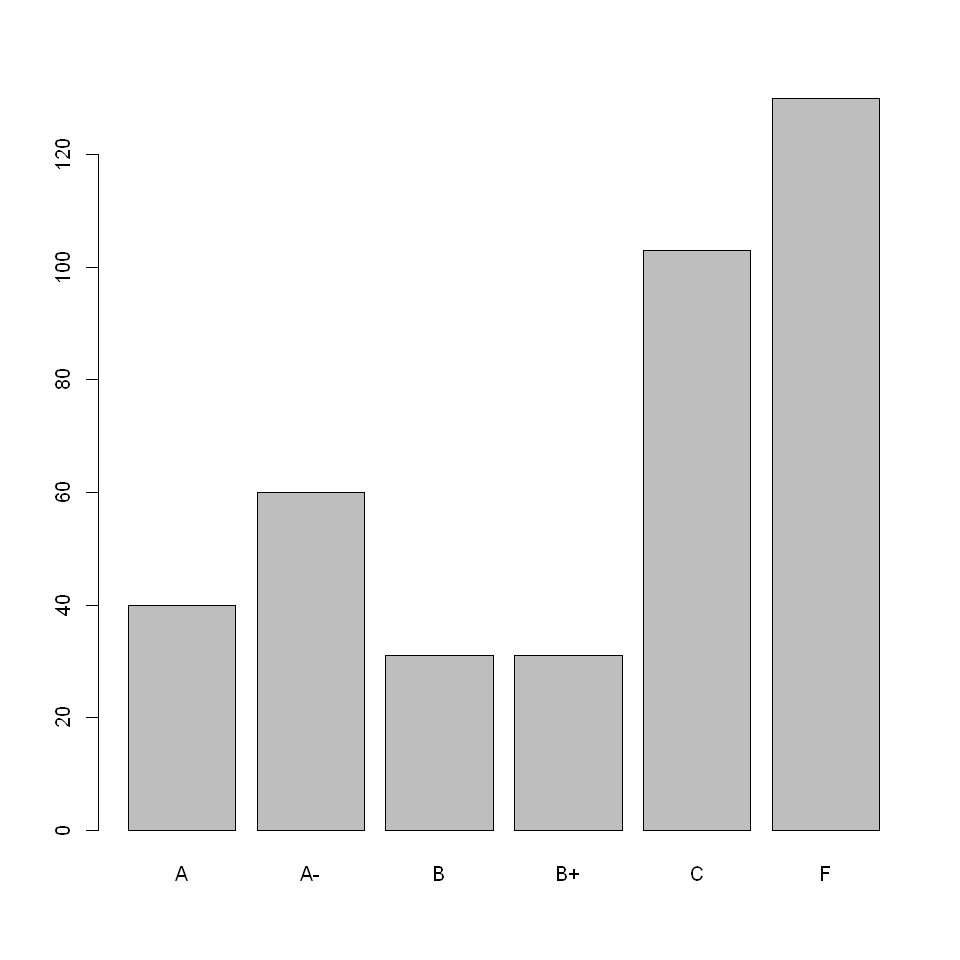

In [132]:
# Víualize the data
options(repr.plot.width=8, repr.plot.height=8)
barplot(table(student$final_grade))

In [121]:
# Drop the numeric target variable
# student$G3 <- NULL

**Test One-vs-All Logistic Regression (LogRes) model, 10-fold CV**

In [133]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_logreg <- makeLearner("classif.multinom", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Run the k-fold CV
resample(lnr_logreg, task_logreg, rdesc, measures=list(mlr::acc))

Resampling: cross-validation

Measures:             acc       



# weights:  258 (210 variable)
initial  value 637.866371 
iter  10 value 398.074710
iter  20 value 317.379755
iter  30 value 230.540723
iter  40 value 179.837042
iter  50 value 122.222210
iter  60 value 77.524889
iter  70 value 49.110583
iter  80 value 28.329407
iter  90 value 19.941669
iter 100 value 11.491829
final  value 11.491829 
stopped after 100 iterations


[Resample] iter 1:    0.6410256 



# weights:  258 (210 variable)
initial  value 636.074612 
iter  10 value 432.065160
iter  20 value 311.989641
iter  30 value 233.963332
iter  40 value 184.362178
iter  50 value 128.115559
iter  60 value 88.314887
iter  70 value 58.594379
iter  80 value 47.102904
iter  90 value 41.931171
iter 100 value 37.116205
final  value 37.116205 
stopped after 100 iterations


[Resample] iter 2:    0.7250000 



# weights:  258 (210 variable)
initial  value 636.074612 
iter  10 value 388.259717
iter  20 value 324.681694
iter  30 value 234.328229
iter  40 value 175.587276
iter  50 value 119.077609
iter  60 value 69.873968
iter  70 value 42.025182
iter  80 value 31.290063
iter  90 value 27.488528
iter 100 value 25.468041
final  value 25.468041 
stopped after 100 iterations


[Resample] iter 3:    0.6500000 



# weights:  258 (210 variable)
initial  value 637.866371 
iter  10 value 404.773326
iter  20 value 323.413307
iter  30 value 230.492817
iter  40 value 175.587049
iter  50 value 104.296531
iter  60 value 56.571263
iter  70 value 5.064497
iter  80 value 0.011350
final  value 0.000086 
converged


[Resample] iter 4:    0.5128205 



# weights:  258 (210 variable)
initial  value 637.866371 
iter  10 value 433.355247
iter  20 value 320.403063
iter  30 value 225.669891
iter  40 value 178.049737
iter  50 value 121.003843
iter  60 value 76.822783
iter  70 value 50.136879
iter  80 value 36.084783
iter  90 value 26.465155
iter 100 value 23.032633
final  value 23.032633 
stopped after 100 iterations


[Resample] iter 5:    0.5641026 



# weights:  258 (210 variable)
initial  value 636.074612 
iter  10 value 410.514064
iter  20 value 313.193805
iter  30 value 237.983743
iter  40 value 183.533494
iter  50 value 123.237658
iter  60 value 85.382142
iter  70 value 59.319376
iter  80 value 46.109808
iter  90 value 35.285693
iter 100 value 29.375780
final  value 29.375780 
stopped after 100 iterations


[Resample] iter 6:    0.6000000 



# weights:  258 (210 variable)
initial  value 637.866371 
iter  10 value 415.111132
iter  20 value 330.979034
iter  30 value 248.726903
iter  40 value 194.388566
iter  50 value 129.132458
iter  60 value 82.484178
iter  70 value 32.111678
iter  80 value 0.390820
iter  90 value 0.000968
final  value 0.000051 
converged


[Resample] iter 7:    0.7179487 



# weights:  258 (210 variable)
initial  value 636.074612 
iter  10 value 388.305512
iter  20 value 322.964458
iter  30 value 229.651493
iter  40 value 172.157420
iter  50 value 107.324949
iter  60 value 58.200983
iter  70 value 31.777692
iter  80 value 23.839929
iter  90 value 20.369894
iter 100 value 18.978707
final  value 18.978707 
stopped after 100 iterations


[Resample] iter 8:    0.5000000 



# weights:  258 (210 variable)
initial  value 637.866371 
iter  10 value 400.211655
iter  20 value 315.506144
iter  30 value 238.526754
iter  40 value 178.769282
iter  50 value 115.773689
iter  60 value 79.531290
iter  70 value 55.103380
iter  80 value 42.286764
iter  90 value 35.583602
iter 100 value 31.598245
final  value 31.598245 
stopped after 100 iterations


[Resample] iter 9:    0.6923077 



# weights:  258 (210 variable)
initial  value 636.074612 
iter  10 value 395.352574
iter  20 value 324.632040
iter  30 value 240.930218
iter  40 value 187.460241
iter  50 value 118.968039
iter  60 value 75.945963
iter  70 value 35.349380
iter  80 value 12.719632
iter  90 value 2.173484
iter 100 value 0.013541
final  value 0.013541 
stopped after 100 iterations


[Resample] iter 10:   0.6000000 




Aggregated Result: acc.test.mean=0.6203205






Resample Result
Task: student
Learner: classif.multinom
Aggr perf: acc.test.mean=0.6203205
Runtime: 1.22338

#### Test Linear Discriminant Analysis (LDA) model, 10-fold CV

In [134]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_lda <- makeLearner("classif.lda", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Run the k-fold CV
resample(lnr_lda, task_logreg, rdesc, measures=list(mlr::acc))

Resampling: cross-validation

Measures:             acc       

[Resample] iter 1:    0.7250000 

[Resample] iter 2:    0.7750000 

[Resample] iter 3:    0.5641026 

[Resample] iter 4:    0.4871795 

[Resample] iter 5:    0.5384615 

[Resample] iter 6:    0.5000000 

[Resample] iter 7:    0.4750000 

[Resample] iter 8:    0.6153846 

[Resample] iter 9:    0.5641026 

[Resample] iter 10:   0.8250000 




Aggregated Result: acc.test.mean=0.6069231






Resample Result
Task: student
Learner: classif.lda
Aggr perf: acc.test.mean=0.6069231
Runtime: 0.268191

**Test Quadratic Discriminant Analysis (QDA) model, 10-fold CV**

In [135]:
# !!! Error caused by the low number of observations in class

# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_qda <- makeLearner("classif.qda", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Run the k-fold CV
resample(lnr_qda, task_logreg, rdesc, measures=list(mlr::acc))

Resampling: cross-validation

Measures:             acc       



ERROR: Error in qda.default(x, grouping, ...): some group is too small for 'qda'


**Test k-Nearest Neighbor (kNN) model, k=1, 10-fold CV**

In [136]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_knn <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T, k=1)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Run the k-fold CV
resample(lnr_knn, task_logreg, rdesc, measures=list(mlr::acc))

Resampling: cross-validation

Measures:             acc       

[Resample] iter 1:    0.3846154 

[Resample] iter 2:    0.3076923 

[Resample] iter 3:    0.3000000 

[Resample] iter 4:    0.4000000 

[Resample] iter 5:    0.2820513 

[Resample] iter 6:    0.2500000 

[Resample] iter 7:    0.3846154 

[Resample] iter 8:    0.3333333 

[Resample] iter 9:    0.3250000 

[Resample] iter 10:   0.3250000 




Aggregated Result: acc.test.mean=0.3292308






Resample Result
Task: student
Learner: classif.kknn
Aggr perf: acc.test.mean=0.3292308
Runtime: 0.186882

**Test k-Nearest Neighbor (kNN) model, k=100, 10-fold CV**

In [137]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_knn <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T, k=100)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Run the k-fold CV
resample(lnr_knn, task_logreg, rdesc, measures=list(mlr::acc))

Resampling: cross-validation

Measures:             acc       

[Resample] iter 1:    0.3750000 

[Resample] iter 2:    0.5750000 

[Resample] iter 3:    0.3846154 

[Resample] iter 4:    0.3750000 

[Resample] iter 5:    0.5128205 

[Resample] iter 6:    0.4615385 

[Resample] iter 7:    0.6410256 

[Resample] iter 8:    0.4250000 

[Resample] iter 9:    0.4750000 

[Resample] iter 10:   0.4358974 




Aggregated Result: acc.test.mean=0.4660897






Resample Result
Task: student
Learner: classif.kknn
Aggr perf: acc.test.mean=0.4660897
Runtime: 0.21502

**Test k-Nearest Neighbor (kNN) model, k=Tuning, 10-fold CV**

In [138]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
lnr_knn <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T)

# Define the task
task_logreg <- makeClassifTask(id="student", data=student, target="final_grade")

# Set hyper parameter tuning
discrete_ps = makeParamSet(
  makeDiscreteParam("k", values = c(1, 5, 10, 20, 50, 100, 200, 300))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
res <- tuneParams(lnr_knn, task=task_logreg, resampling=rdesc,
  par.set=discrete_ps, control=ctrl, measures=list(mlr::acc))

[Tune] Started tuning learner classif.kknn for parameter set:

      Type len Def                   Constr Req Tunable Trafo
k discrete   -   - 1,5,10,20,50,100,200,300   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: k=1

[Tune-y] 1: acc.test.mean=0.3616667; time: 0.0 min

[Tune-x] 2: k=5

[Tune-y] 2: acc.test.mean=0.3616667; time: 0.0 min

[Tune-x] 3: k=10

[Tune-y] 3: acc.test.mean=0.3868590; time: 0.0 min

[Tune-x] 4: k=20

[Tune-y] 4: acc.test.mean=0.4069872; time: 0.0 min

[Tune-x] 5: k=50

[Tune-y] 5: acc.test.mean=0.4454487; time: 0.0 min

[Tune-x] 6: k=100

[Tune-y] 6: acc.test.mean=0.4506410; time: 0.0 min

[Tune-x] 7: k=200

[Tune-y] 7: acc.test.mean=0.4454487; time: 0.0 min

[Tune-x] 8: k=300

[Tune-y] 8: acc.test.mean=0.4151282; time: 0.0 min

[Tune] Result: k=100 : acc.test.mean=0.4506410



## Homework
- Exercise 6 (p.170, Chap.4), 8 (p.170, Chap.4), 9 (p.170, Chap.4), 10 (p.171, Chap.4) and 11 (p.171, Chap.4).

Ex. 6

In [4]:
#point a)
px = (exp(-6+0.05 * 40 + 3.5)/(1+ exp(-6+0.05 * 40 + 3.5)))
px

[1] 0.3775407

In [9]:
#point b)
#after keeping X1 as an unknown variable, fixing the probability = 0.50, we get
X1 = -(-6 +3.5)/0.05

In [10]:
X1

[1] 50

So he will have to study 50 hours to have a 50% change of getting an A in class.

Ex. 8

So being the 18% the average error rate between test and training data sets, and being the KNN made with K=1, we have that the training error is 0, which leads to the fact that the test error is 36%. For this reason it is better to choose the logistic regressor.

Ex. 9

In [11]:
#point a)
#Having a log odd of 0.37, by making the inverse calculation we get
p = 0.37 / (1 +0.37) 
p

[1] 0.270073

We hence have on average 27% of people that default in paying their credit card balance.

In [12]:
#point b)
#if an individual has a 16% of change of defaulting, her / his odds will be
log_odd = 0.16 / (1-0.16)
log_odd

[1] 0.1904762

Ex. 10

In [13]:
#point a)
library(ISLR)
summary(Weekly)

Warning message:
"package 'ISLR' was built under R version 3.6.3"

      Year           Lag1               Lag2               Lag3         
 Min.   :1990   Min.   :-18.1950   Min.   :-18.1950   Min.   :-18.1950  
 1st Qu.:1995   1st Qu.: -1.1540   1st Qu.: -1.1540   1st Qu.: -1.1580  
 Median :2000   Median :  0.2410   Median :  0.2410   Median :  0.2410  
 Mean   :2000   Mean   :  0.1506   Mean   :  0.1511   Mean   :  0.1472  
 3rd Qu.:2005   3rd Qu.:  1.4050   3rd Qu.:  1.4090   3rd Qu.:  1.4090  
 Max.   :2010   Max.   : 12.0260   Max.   : 12.0260   Max.   : 12.0260  
      Lag4               Lag5              Volume            Today         
 Min.   :-18.1950   Min.   :-18.1950   Min.   :0.08747   Min.   :-18.1950  
 1st Qu.: -1.1580   1st Qu.: -1.1660   1st Qu.:0.33202   1st Qu.: -1.1540  
 Median :  0.2380   Median :  0.2340   Median :1.00268   Median :  0.2410  
 Mean   :  0.1458   Mean   :  0.1399   Mean   :1.57462   Mean   :  0.1499  
 3rd Qu.:  1.4090   3rd Qu.:  1.4050   3rd Qu.:2.05373   3rd Qu.:  1.4050  
 Max.   : 12.0260   Max.   : 12.0

In [14]:
cor(Weekly[, -9])

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000000,-0.032289274,-0.03339001,-0.03000649,-0.031127923,-0.030519101,0.84194162,-0.032459894
Lag1,-0.03228927,1.000000000,-0.07485305,0.05863568,-0.071273876,-0.008183096,-0.06495131,-0.075031842
Lag2,-0.03339001,-0.074853051,1.00000000,-0.07572091,0.058381535,-0.072499482,-0.08551314,0.059166717
Lag3,-0.03000649,0.058635682,-0.07572091,1.00000000,-0.075395865,0.060657175,-0.06928771,-0.071243639
Lag4,-0.03112792,-0.071273876,0.05838153,-0.07539587,1.000000000,-0.075675027,-0.06107462,-0.007825873
Lag5,-0.03051910,-0.008183096,-0.07249948,0.06065717,-0.075675027,1.000000000,-0.05851741,0.011012698
Volume,0.84194162,-0.064951313,-0.08551314,-0.06928771,-0.061074617,-0.058517414,1.00000000,-0.033077783
Today,-0.03245989,-0.075031842,0.05916672,-0.07124364,-0.007825873,0.011012698,-0.03307778,1.000000000


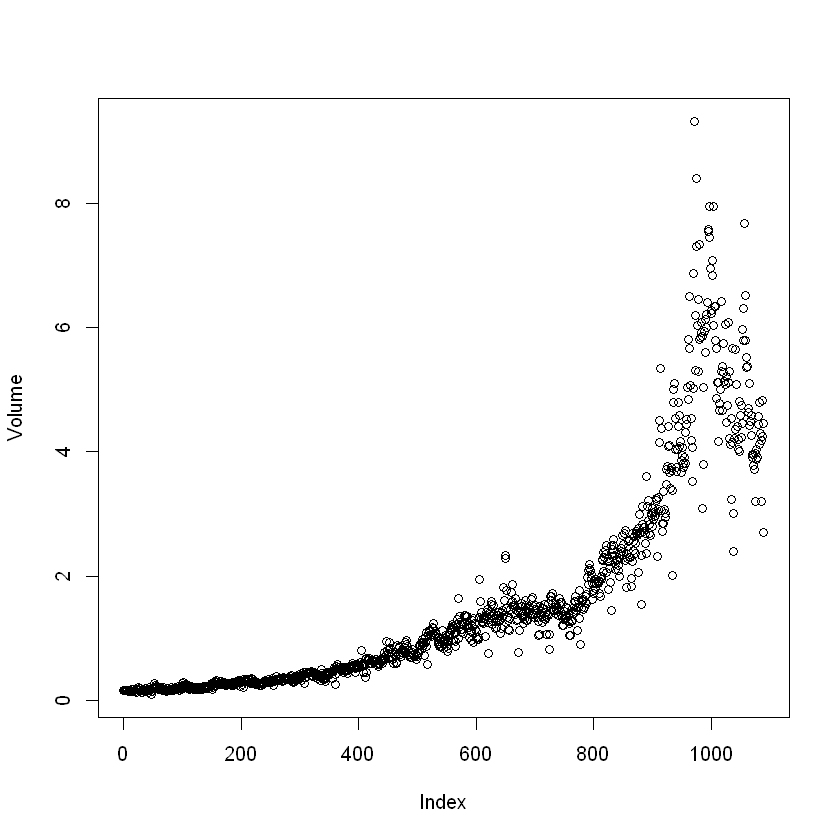

In [15]:
#to look for some patterns
attach(Weekly)
plot(Volume)

So the only relevant correlation is between Volume and Year. In fact, volume rises when we go on with the dates.

In [17]:
#point b)
fit.glm <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, data = Weekly, family = binomial)
summary(fit.glm)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Weekly)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6949  -1.2565   0.9913   1.0849   1.4579  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.26686    0.08593   3.106   0.0019 **
Lag1        -0.04127    0.02641  -1.563   0.1181   
Lag2         0.05844    0.02686   2.175   0.0296 * 
Lag3        -0.01606    0.02666  -0.602   0.5469   
Lag4        -0.02779    0.02646  -1.050   0.2937   
Lag5        -0.01447    0.02638  -0.549   0.5833   
Volume      -0.02274    0.03690  -0.616   0.5377   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1496.2  on 1088  degrees of freedom
Residual deviance: 1486.4  on 1082  degrees of freedom
AIC: 1500.4

Number of Fisher Scoring iterations: 4


Lag 2 is the only significant predictor.

In [18]:
#point c)
probs <- predict(fit.glm, type = "response")
pred.glm <- rep("Down", length(probs))
pred.glm[probs > 0.5] <- "Up"
table(pred.glm, Direction)

        Direction
pred.glm Down  Up
    Down   54  48
    Up    430 557

In [19]:
#point d)
train <- (Year < 2009)
Weekly.20092010 <- Weekly[!train, ]
Direction.20092010 <- Direction[!train]
fit.glm2 <- glm(Direction ~ Lag2, data = Weekly, family = binomial, subset = train)
summary(fit.glm2)


Call:
glm(formula = Direction ~ Lag2, family = binomial, data = Weekly, 
    subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.536  -1.264   1.021   1.091   1.368  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.20326    0.06428   3.162  0.00157 **
Lag2         0.05810    0.02870   2.024  0.04298 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1354.7  on 984  degrees of freedom
Residual deviance: 1350.5  on 983  degrees of freedom
AIC: 1354.5

Number of Fisher Scoring iterations: 4


In [20]:
probs2 <- predict(fit.glm2, Weekly.20092010, type = "response")
pred.glm2 <- rep("Down", length(probs2))
pred.glm2[probs2 > 0.5] <- "Up"
table(pred.glm2, Direction.20092010)

         Direction.20092010
pred.glm2 Down Up
     Down    9  5
     Up     34 56

In [21]:
#point e)
library(MASS)
fit.lda <- lda(Direction ~ Lag2, data = Weekly, subset = train)
fit.lda

Warning message:
"package 'MASS' was built under R version 3.6.3"

Call:
lda(Direction ~ Lag2, data = Weekly, subset = train)

Prior probabilities of groups:
     Down        Up 
0.4477157 0.5522843 

Group means:
            Lag2
Down -0.03568254
Up    0.26036581

Coefficients of linear discriminants:
           LD1
Lag2 0.4414162

In [22]:
pred.lda <- predict(fit.lda, Weekly.20092010)
table(pred.lda$class, Direction.20092010)

      Direction.20092010
       Down Up
  Down    9  5
  Up     34 56

In [23]:
#point f)
fit.qda <- qda(Direction ~ Lag2, data = Weekly, subset = train)
fit.qda

Call:
qda(Direction ~ Lag2, data = Weekly, subset = train)

Prior probabilities of groups:
     Down        Up 
0.4477157 0.5522843 

Group means:
            Lag2
Down -0.03568254
Up    0.26036581

In [ ]:
pred.qda <- predict(fit.qda, Weekly.20092010)
table(pred.qda$class, Direction.20092010)

In [24]:
#point g)
library(class)
train.X <- as.matrix(Lag2[train])
test.X <- as.matrix(Lag2[!train])
train.Direction <- Direction[train]
set.seed(1)
pred.knn <- knn(train.X, test.X, train.Direction, k = 1)
table(pred.knn, Direction.20092010)

        Direction.20092010
pred.knn Down Up
    Down   21 30
    Up     22 31

In [25]:
#pount h)

Logistic regression is the best together with LDA, then we have QDA and KNN.

In [26]:
#point i)
#Logistic regression with Lag2:Lag1
fit.glm3 <- glm(Direction ~ Lag2:Lag1, data = Weekly, family = binomial, subset = train)
probs3 <- predict(fit.glm3, Weekly.20092010, type = "response")
pred.glm3 <- rep("Down", length(probs3))
pred.glm3[probs3 > 0.5] = "Up"
table(pred.glm3, Direction.20092010)

         Direction.20092010
pred.glm3 Down Up
     Down    1  1
     Up     42 60

In [27]:
mean(pred.glm3 == Direction.20092010)

[1] 0.5865385

In [28]:
# LDA with Lag2 interaction with Lag1
fit.lda2 <- lda(Direction ~ Lag2:Lag1, data = Weekly, subset = train)
pred.lda2 <- predict(fit.lda2, Weekly.20092010)
mean(pred.lda2$class == Direction.20092010)

[1] 0.5769231

In [29]:
# QDA with sqrt(abs(Lag2))
fit.qda2 <- qda(Direction ~ Lag2 + sqrt(abs(Lag2)), data = Weekly, subset = train)
pred.qda2 <- predict(fit.qda2, Weekly.20092010)
table(pred.qda2$class, Direction.20092010)

      Direction.20092010
       Down Up
  Down   12 13
  Up     31 48

In [30]:
mean(pred.qda2$class == Direction.20092010)

[1] 0.5769231

In [31]:
# KNN k =10
pred.knn2 <- knn(train.X, test.X, train.Direction, k = 10)
table(pred.knn2, Direction.20092010)

         Direction.20092010
pred.knn2 Down Up
     Down   17 18
     Up     26 43

In [32]:
mean(pred.knn2 == Direction.20092010)

[1] 0.5769231

In [33]:
# KNN k = 100
pred.knn3 <- knn(train.X, test.X, train.Direction, k = 100)
table(pred.knn3, Direction.20092010)

         Direction.20092010
pred.knn3 Down Up
     Down    9 12
     Up     34 49

In [34]:
mean(pred.knn3 == Direction.20092010)

[1] 0.5576923

Ex. 11

In [36]:
#point a)
attach(Auto)
mpg01 <- rep(0, length(mpg))
mpg01[mpg > median(mpg)] <- 1
Auto <- data.frame(Auto, mpg01)

The following object is masked _by_ .GlobalEnv:

    mpg01

The following objects are masked from Auto (pos = 3):

    acceleration, cylinders, displacement, horsepower, mpg, name,
    origin, weight, year



In [37]:
#point b)
#as we did above
cor(Auto[, -9])

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01,mpg01.1
mpg,1.0000000,-0.7776175,-0.8051269,-0.7784268,-0.8322442,0.4233285,0.5805410,0.5652088,0.8369392,0.8369392
cylinders,-0.7776175,1.0000000,0.9508233,0.8429834,0.8975273,-0.5046834,-0.3456474,-0.5689316,-0.7591939,-0.7591939
displacement,-0.8051269,0.9508233,1.0000000,0.8972570,0.9329944,-0.5438005,-0.3698552,-0.6145351,-0.7534766,-0.7534766
horsepower,-0.7784268,0.8429834,0.8972570,1.0000000,0.8645377,-0.6891955,-0.4163615,-0.4551715,-0.6670526,-0.6670526
weight,-0.8322442,0.8975273,0.9329944,0.8645377,1.0000000,-0.4168392,-0.3091199,-0.5850054,-0.7577566,-0.7577566
acceleration,0.4233285,-0.5046834,-0.5438005,-0.6891955,-0.4168392,1.0000000,0.2903161,0.2127458,0.3468215,0.3468215
year,0.5805410,-0.3456474,-0.3698552,-0.4163615,-0.3091199,0.2903161,1.0000000,0.1815277,0.4299042,0.4299042
origin,0.5652088,-0.5689316,-0.6145351,-0.4551715,-0.5850054,0.2127458,0.1815277,1.0000000,0.5136984,0.5136984
mpg01,0.8369392,-0.7591939,-0.7534766,-0.6670526,-0.7577566,0.3468215,0.4299042,0.5136984,1.0000000,1.0000000
mpg01.1,0.8369392,-0.7591939,-0.7534766,-0.6670526,-0.7577566,0.3468215,0.4299042,0.5136984,1.0000000,1.0000000


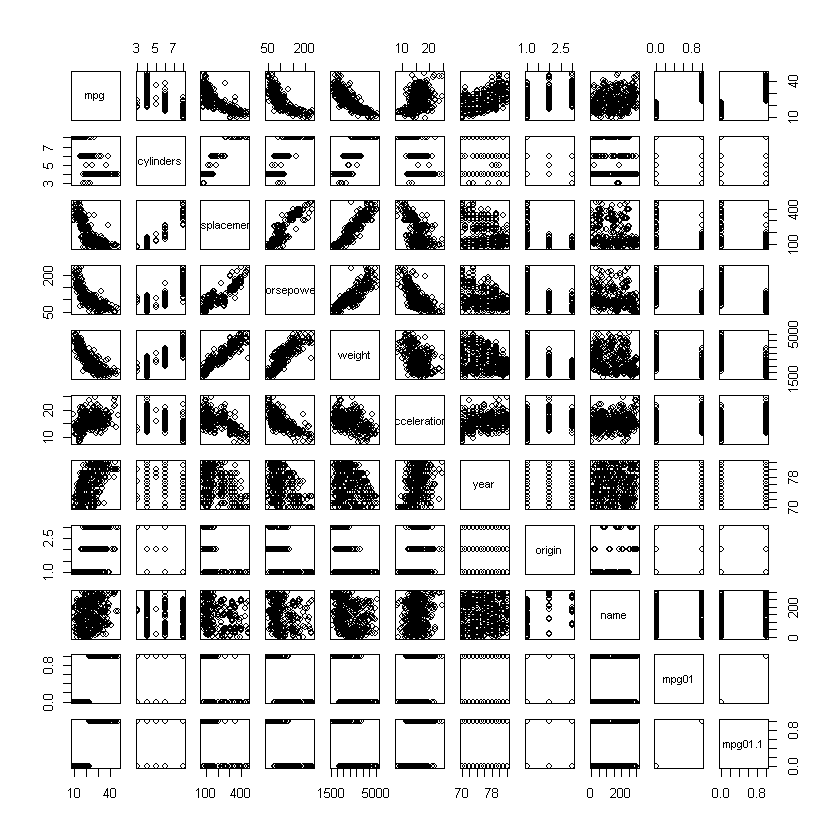

In [38]:
pairs(Auto)

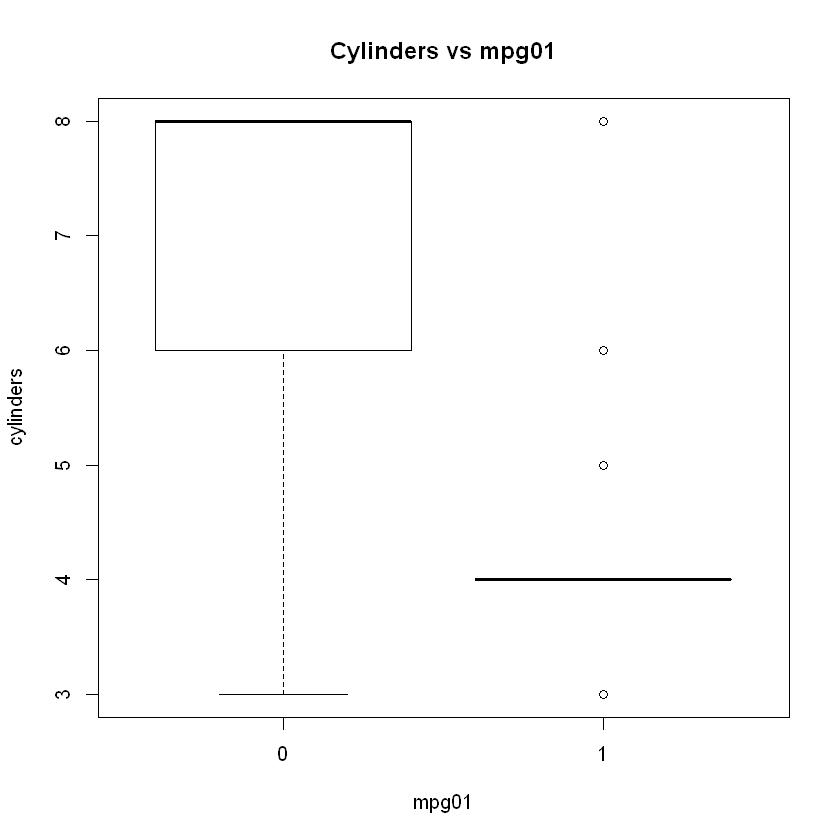

In [39]:
boxplot(cylinders ~ mpg01, data = Auto, main = "Cylinders vs mpg01")

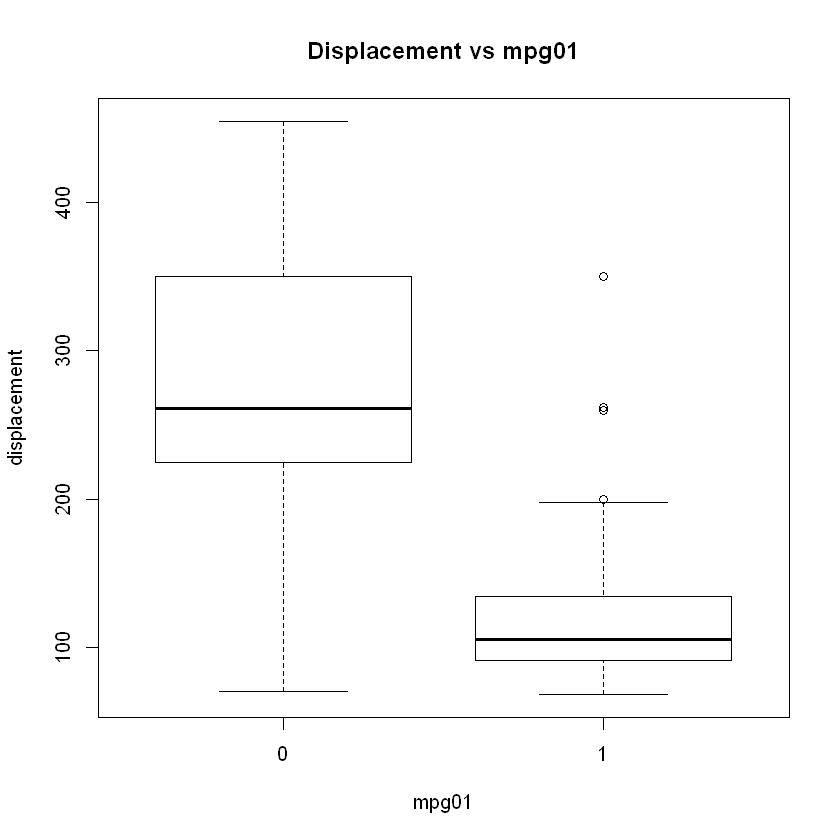

In [40]:
boxplot(displacement ~ mpg01, data = Auto, main = "Displacement vs mpg01")

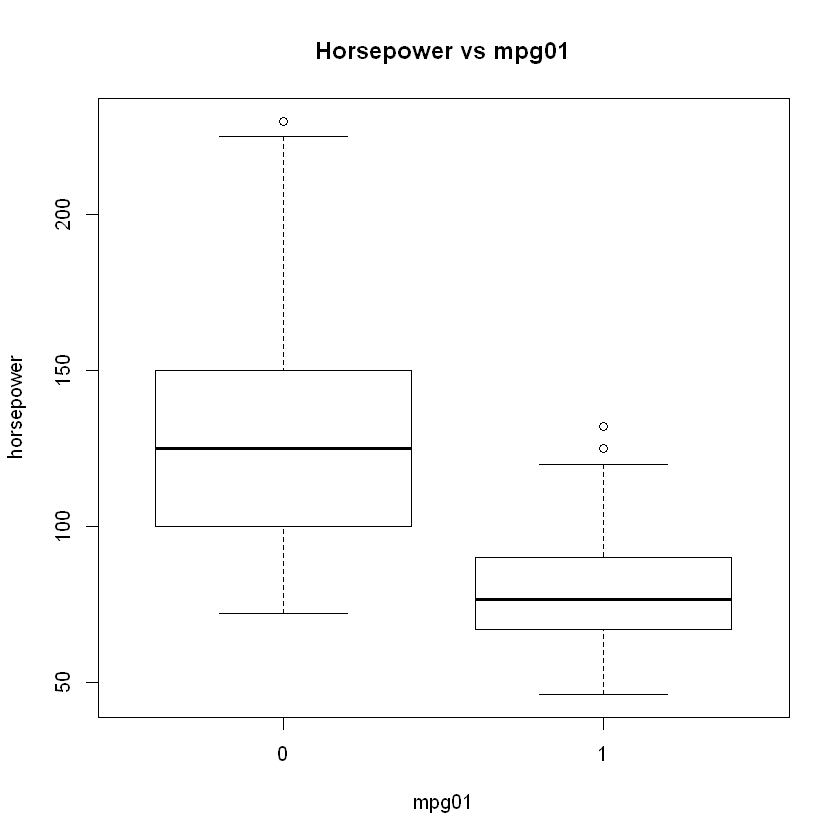

In [41]:
boxplot(horsepower ~ mpg01, data = Auto, main = "Horsepower vs mpg01")

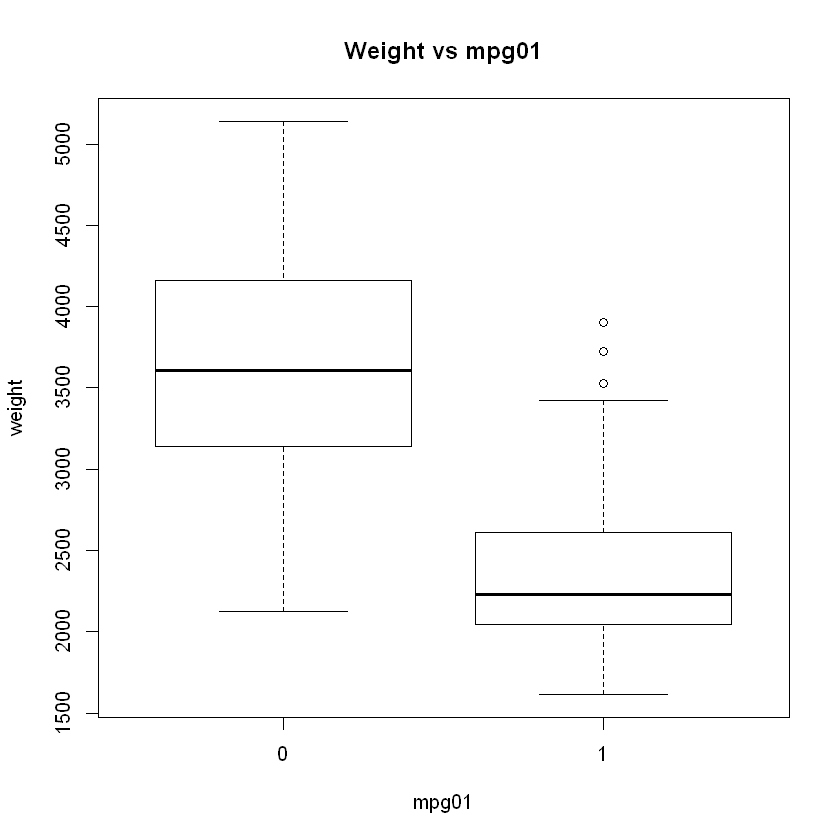

In [42]:
boxplot(weight ~ mpg01, data = Auto, main = "Weight vs mpg01")

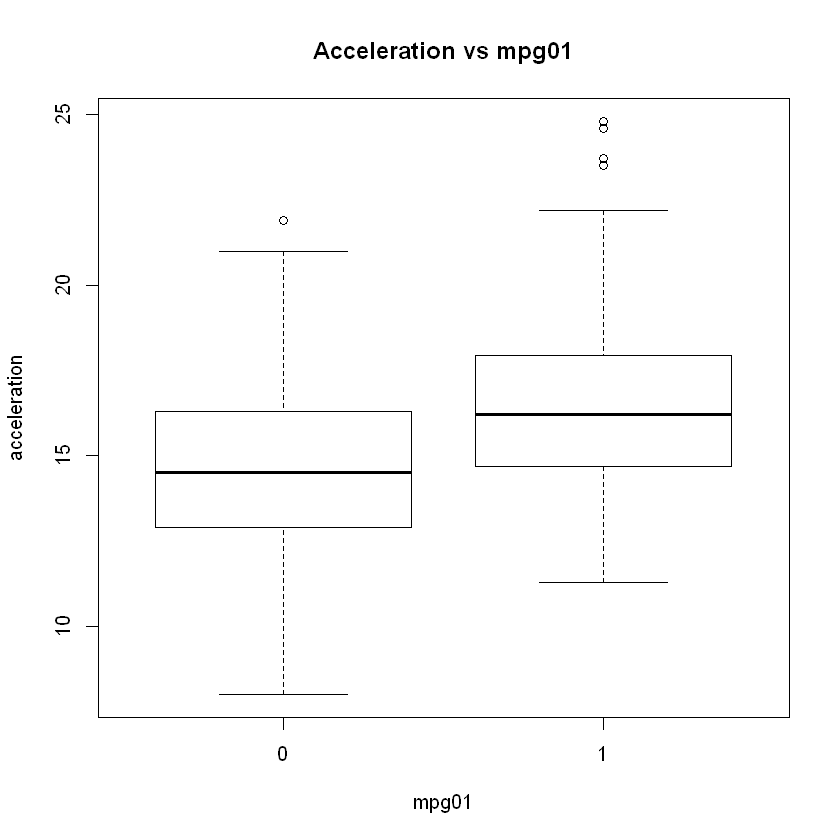

In [43]:
boxplot(acceleration ~ mpg01, data = Auto, main = "Acceleration vs mpg01")

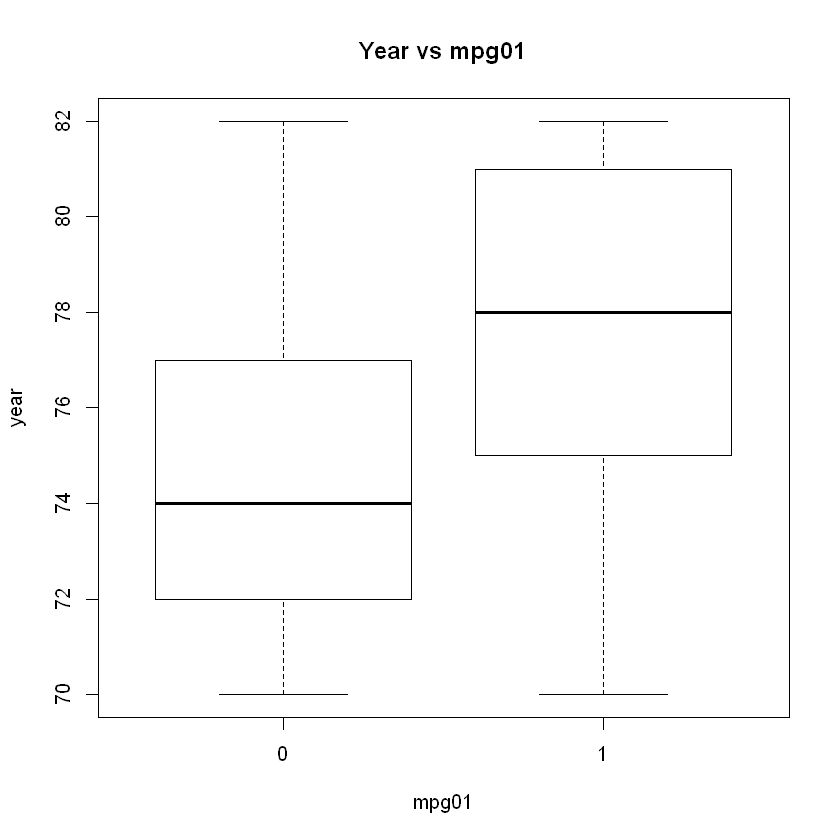

In [44]:
boxplot(year ~ mpg01, data = Auto, main = "Year vs mpg01")

So we say there is some association between mpg01 and cylinders, weight, displacement and horsepower.

In [45]:
#point c)
train <- (year %% 2 == 0)
Auto.train <- Auto[train, ]
Auto.test <- Auto[!train, ]
mpg01.test <- mpg01[!train]

In [46]:
#point d)
fit.lda <- lda(mpg01 ~ cylinders + weight + displacement + horsepower, data = Auto, subset = train)
fit.lda

Call:
lda(mpg01 ~ cylinders + weight + displacement + horsepower, data = Auto, 
    subset = train)

Prior probabilities of groups:
        0         1 
0.4571429 0.5428571 

Group means:
  cylinders   weight displacement horsepower
0  6.812500 3604.823     271.7396  133.14583
1  4.070175 2314.763     111.6623   77.92105

Coefficients of linear discriminants:
                       LD1
cylinders    -0.6741402638
weight       -0.0011465750
displacement  0.0004481325
horsepower    0.0059035377

In [47]:
pred.lda <- predict(fit.lda, Auto.test)
table(pred.lda$class, mpg01.test)

   mpg01.test
     0  1
  0 86  9
  1 14 73

In [48]:
mean(pred.lda$class != mpg01.test)

[1] 0.1263736

Test error rate of 12.63%.

In [49]:
#point e)
fit.qda <- qda(mpg01 ~ cylinders + weight + displacement + horsepower, data = Auto, subset = train)
fit.qda

Call:
qda(mpg01 ~ cylinders + weight + displacement + horsepower, data = Auto, 
    subset = train)

Prior probabilities of groups:
        0         1 
0.4571429 0.5428571 

Group means:
  cylinders   weight displacement horsepower
0  6.812500 3604.823     271.7396  133.14583
1  4.070175 2314.763     111.6623   77.92105

In [50]:
pred.qda <- predict(fit.qda, Auto.test)
table(pred.qda$class, mpg01.test)

   mpg01.test
     0  1
  0 89 13
  1 11 69

In [51]:
mean(pred.qda$class != mpg01.test)

[1] 0.1318681

Test error rate of 13.18%.

In [52]:
#point f)
fit.glm <- glm(mpg01 ~ cylinders + weight + displacement + horsepower, data = Auto, family = binomial, subset = train)
summary(fit.glm)


Call:
glm(formula = mpg01 ~ cylinders + weight + displacement + horsepower, 
    family = binomial, data = Auto, subset = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.48027  -0.03413   0.10583   0.29634   2.57584  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  17.658730   3.409012   5.180 2.22e-07 ***
cylinders    -1.028032   0.653607  -1.573   0.1158    
weight       -0.002922   0.001137  -2.569   0.0102 *  
displacement  0.002462   0.015030   0.164   0.8699    
horsepower   -0.050611   0.025209  -2.008   0.0447 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 289.58  on 209  degrees of freedom
Residual deviance:  83.24  on 205  degrees of freedom
AIC: 93.24

Number of Fisher Scoring iterations: 7


In [53]:
probs <- predict(fit.glm, Auto.test, type = "response")
pred.glm <- rep(0, length(probs))
pred.glm[probs > 0.5] <- 1
table(pred.glm, mpg01.test)

        mpg01.test
pred.glm  0  1
       0 89 11
       1 11 71

In [54]:
mean(pred.glm != mpg01.test)

[1] 0.1208791

Test error rate of 12.09%.

In [55]:
#point g)
train.X <- cbind(cylinders, weight, displacement, horsepower)[train, ]
test.X <- cbind(cylinders, weight, displacement, horsepower)[!train, ]
train.mpg01 <- mpg01[train]
set.seed(1)
pred.knn <- knn(train.X, test.X, train.mpg01, k = 1)
table(pred.knn, mpg01.test)

        mpg01.test
pred.knn  0  1
       0 83 11
       1 17 71

In [56]:
mean(pred.knn != mpg01.test)

[1] 0.1538462

In [57]:
pred.knn <- knn(train.X, test.X, train.mpg01, k = 10)
table(pred.knn, mpg01.test)

        mpg01.test
pred.knn  0  1
       0 77  7
       1 23 75

In [58]:
mean(pred.knn != mpg01.test)

[1] 0.1648352

Test error rate of 16.48% for K=10.

In [59]:
pred.knn <- knn(train.X, test.X, train.mpg01, k = 100)
table(pred.knn, mpg01.test)

        mpg01.test
pred.knn  0  1
       0 81  7
       1 19 75

In [60]:
mean(pred.knn != mpg01.test)

[1] 0.1428571

Test error rate of 14.28% for K=100. Hence, a K value of 100 seems to perform the best.